In [1]:
%load_ext autoreload
%autoreload 2

### Preprocessing scmultiome data from Curtis Boswell.
Analysis of single nuclear expression data only.

Modeling vertebrate organogenesis in zebrafish across 3 timepoints (12hr, 18hr, 24hr).

Matched ATAC data is available for each cell.

Aim: map transcription factor activation controlling lineage differentiation during vertebrate orgnogenesis.

# Setup

In [79]:
import os, pickle, scprep, warnings, scanpy as sc 
warnings.filterwarnings('ignore')

# NOTE: for handling waaaaaay too many plots
from IPython.display import clear_output

from degex.preprocessing import (
    prepare_h5ad_file,
    filter_pipeline,
    normalization_pipeline,
    embedding_pipeline,
)

In [74]:
# filtered_bc matricies are small enough that they are in the git repo and can be accessed locally
DATA_DIR = os.path.abspath('../data')

# location on Farnam _shared_ project data
FARNAM_DIR = '/gpfs/gibbs/pi/krishnaswamy_smita/Boswell_Multiome_2023'

RAW_DIR = os.path.join(FARNAM_DIR, 'raw')

In [3]:
def make_filename(hr:str, data_dir:str=DATA_DIR):
    rootname = 'scmultiome_121824_seq2'
    return os.path.join(
        data_dir, 
        f'{rootname}_{hr}_cr200_run1',
        'filtered_feature_bc_matrix.h5'
    )

f1 = make_filename('12h')
f2 = make_filename('18h')
f3 = make_filename('24h')

## Load Data

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.61
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 4.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.2%
Elapsed time: 4.4 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.6%
Estimated detectable doublet fraction = 6.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 9.3%
Elapsed time: 2.5 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.59
Detected doublet rate = 0.6%
Estimated detectable doublet fraction = 6.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 9.7%
Elapsed time: 0.9 seconds


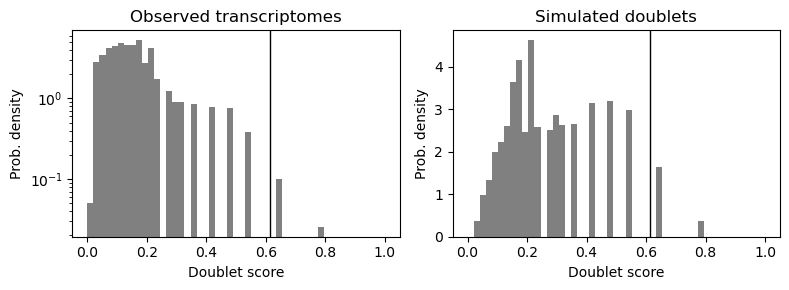

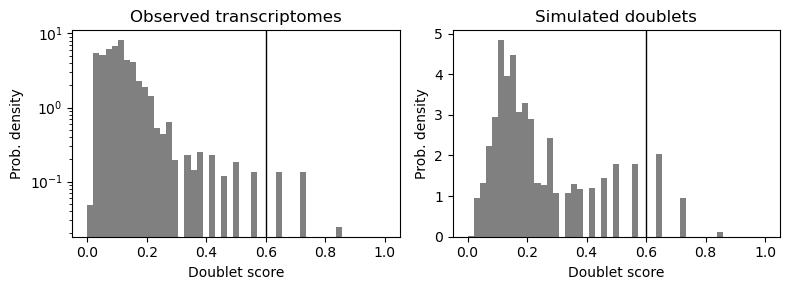

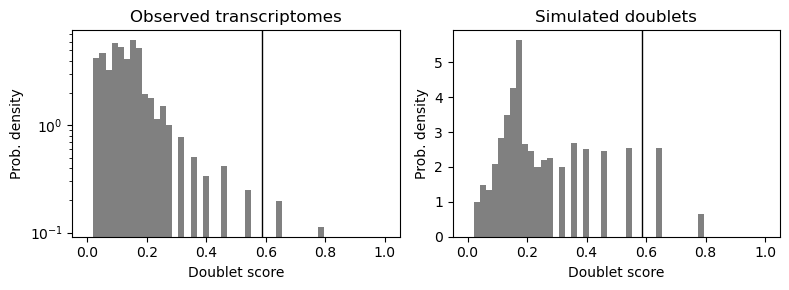

In [4]:
sdata1 = prepare_h5ad_file(f1, plot=True)
sdata2 = prepare_h5ad_file(f2, plot=True)
sdata3 = prepare_h5ad_file(f3, plot=True)

## Stack and run QC
**NOTE**: these values have already been fine tuned by Scott Youlten

In [5]:
from degex.adata import (
    combine_timepoints, add_gene_annotations,
    calc_qc_stats
) 

In [6]:
adata = combine_timepoints(
    sdata1, sdata2, sdata3, 
    idx_to_time={'0': '12hr', '1': '18hr', '2': '24hr'},
    print_counts=True
)

18hr    4056
12hr    1944
24hr    1748
Name: batch, dtype: int64


In [7]:
adata = add_gene_annotations(
    adata, 
    os.path.join(DATA_DIR, 'genes', 'Gene_annotation.csv'),    
)

In [8]:
adata = calc_qc_stats(adata)

In [11]:
from degex.types import CutoffSpecification
adata = filter_pipeline(
    adata, 
    cutoff_specs=[
        CutoffSpecification('total_counts', 500, 10000),
        CutoffSpecification('pct_counts_mito', None, 15),
        # CutoffSpecification('pct_counts_ribo', None, 15),
        # CutoffSpecification('doublet_scores', None, 0.4),
    ],
    min_cells=5
)
adata.obs.batch.value_counts()

18hr    3544
12hr    1708
24hr    1542
Name: batch, dtype: int64

<Axes: ylabel='Number of cells'>

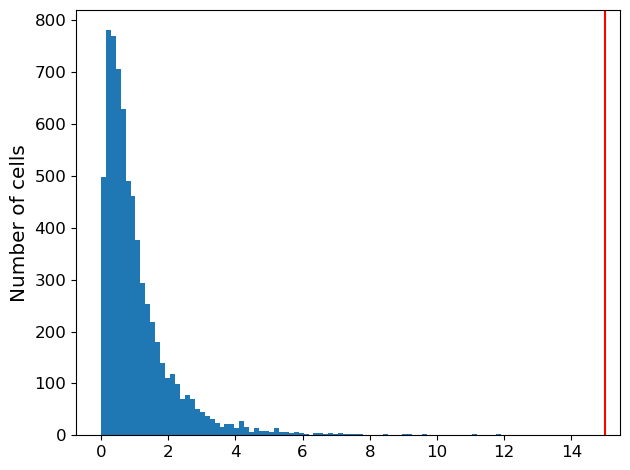

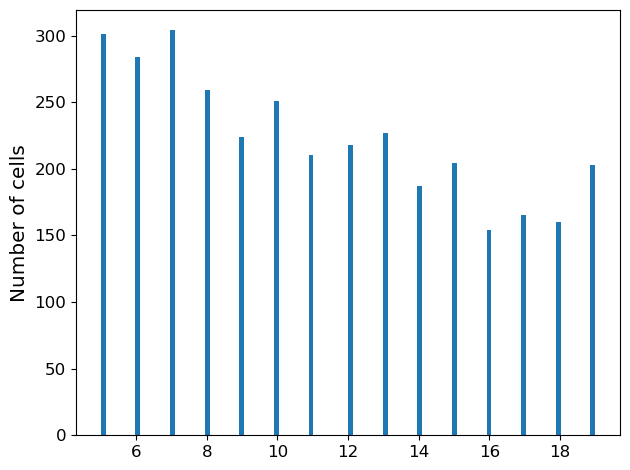

In [12]:
scprep.plot.histogram(adata.obs["pct_counts_mito"], cutoff=15)
scprep.plot.histogram(adata[:,adata.var.n_cells_by_counts < 20].var["n_cells_by_counts"])

## Score cell cycle

In [13]:
from degex.types import VAR_HUMAN_GENE_SYMBOL
cell_cycle_genes = [
    x.strip() 
    for x in open(f'{DATA_DIR}/genes/regev_lab_cell_cycle_genes.txt')
]
s_genes = cell_cycle_genes[:43]
s_genes = adata.var.index[adata.var[VAR_HUMAN_GENE_SYMBOL].isin(s_genes)]
g2m_genes = cell_cycle_genes[43:]
g2m_genes = adata.var.index[adata.var[VAR_HUMAN_GENE_SYMBOL].isin(g2m_genes)]


## Normalize

In [14]:
adata = normalization_pipeline(adata, s_genes, g2m_genes)

## Embeddings

In [15]:
adata, g, g_hvg = embedding_pipeline(adata)

g is None. Will attempt to calculate with PCA stored in adata.obsm[X_pca].
Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 6794 observations.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.01 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.36 seconds.
    Calculating KMeans...
    Calculated KMeans in 1.30 seconds.
  Calculated landmark operator in 2.50 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.26 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.90 seconds.
Calculated PHATE in 6.68 seconds.
Unique HVGs after 12hr 2178
Unique HVGs after 18hr 2987
Unique HVGs after 24hr 3318
g is None. Will attempt to calculate with PCA stored in adata.obsm[X_pca_hvg].
Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 6794 observations.
  Calculating graph and diffusion operator...
  Calculated graph and diffusi

In [16]:
VOIs=['total_counts', 'pct_counts_mito', 'pct_counts_ribo', 'pct_counts_in_top_50_genes', 'n_genes_by_counts', 'phase', 'batch', 'doublet_scores']

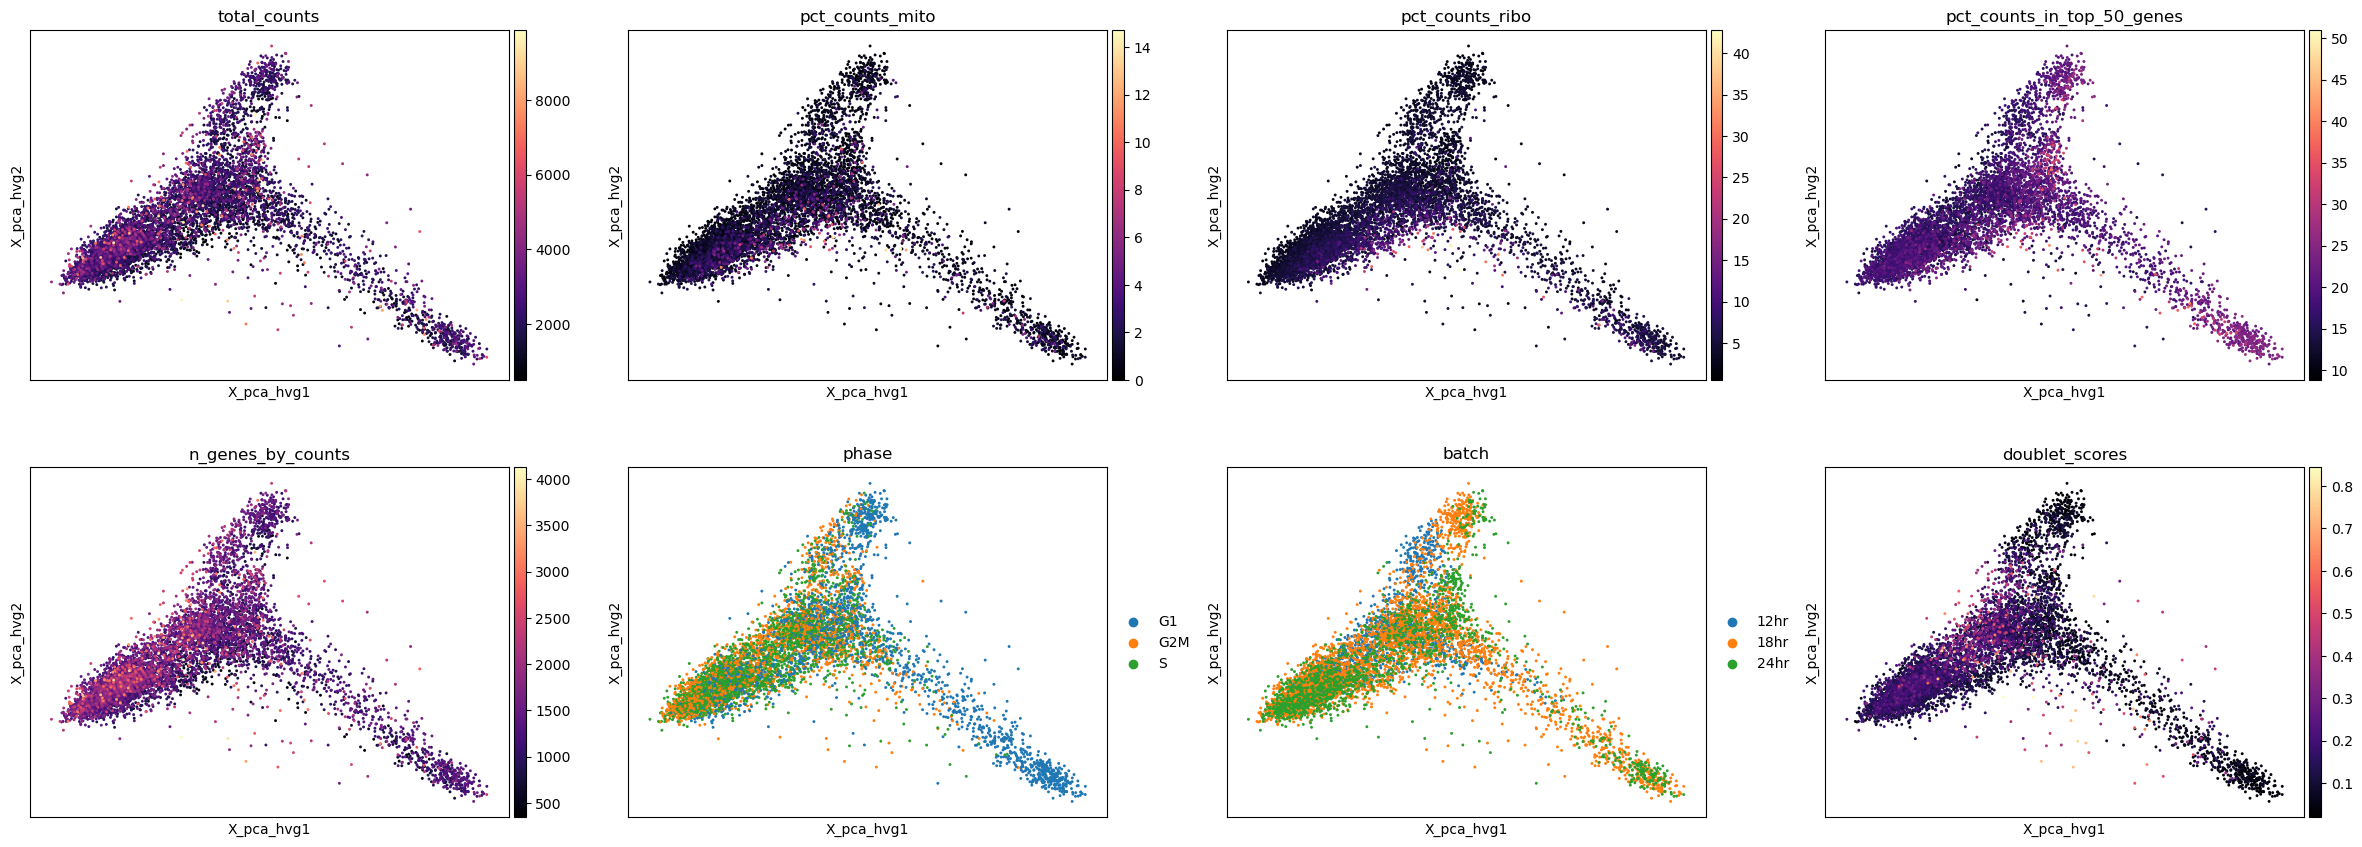

In [17]:
sc.pl.embedding(adata, basis='X_pca_hvg', color=VOIs, color_map='magma')

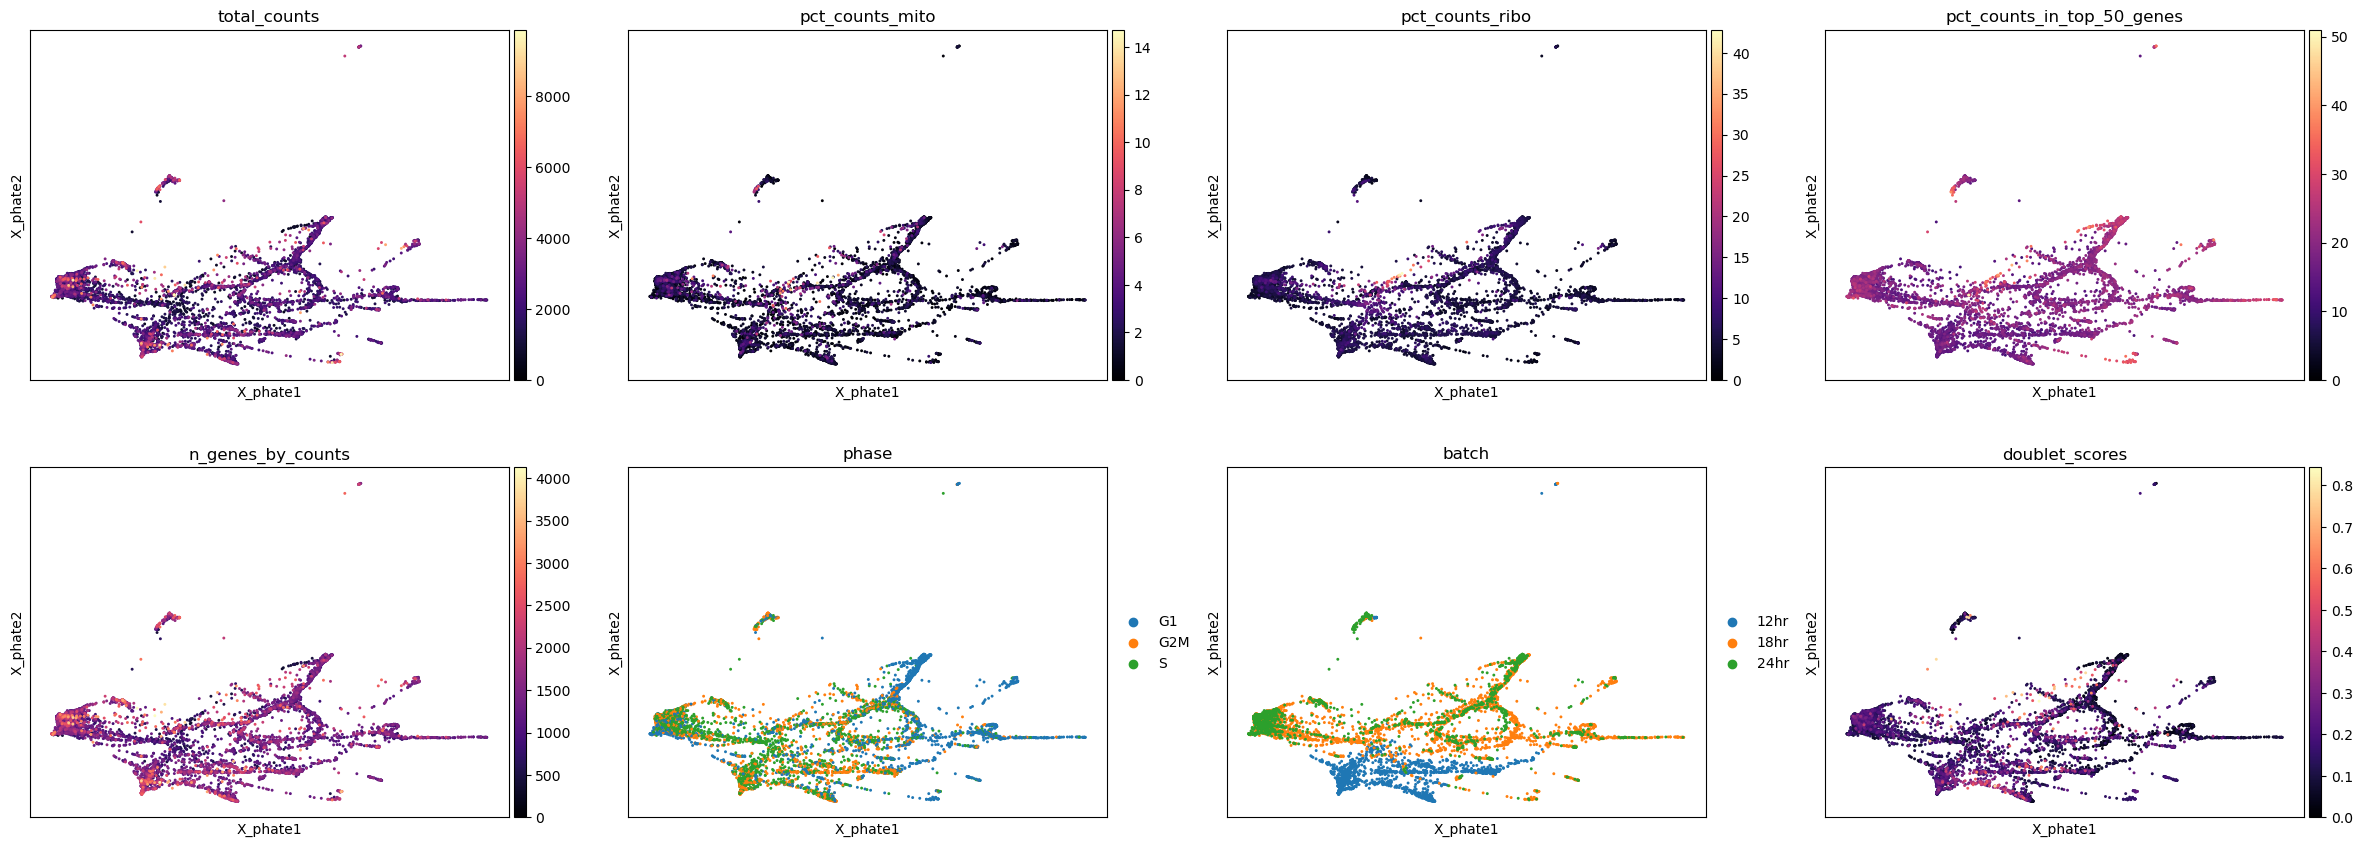

In [18]:
sc.pl.embedding(adata, basis='X_phate', sort_order=True, vmin=0, color=VOIs, use_raw = False, color_map='magma')

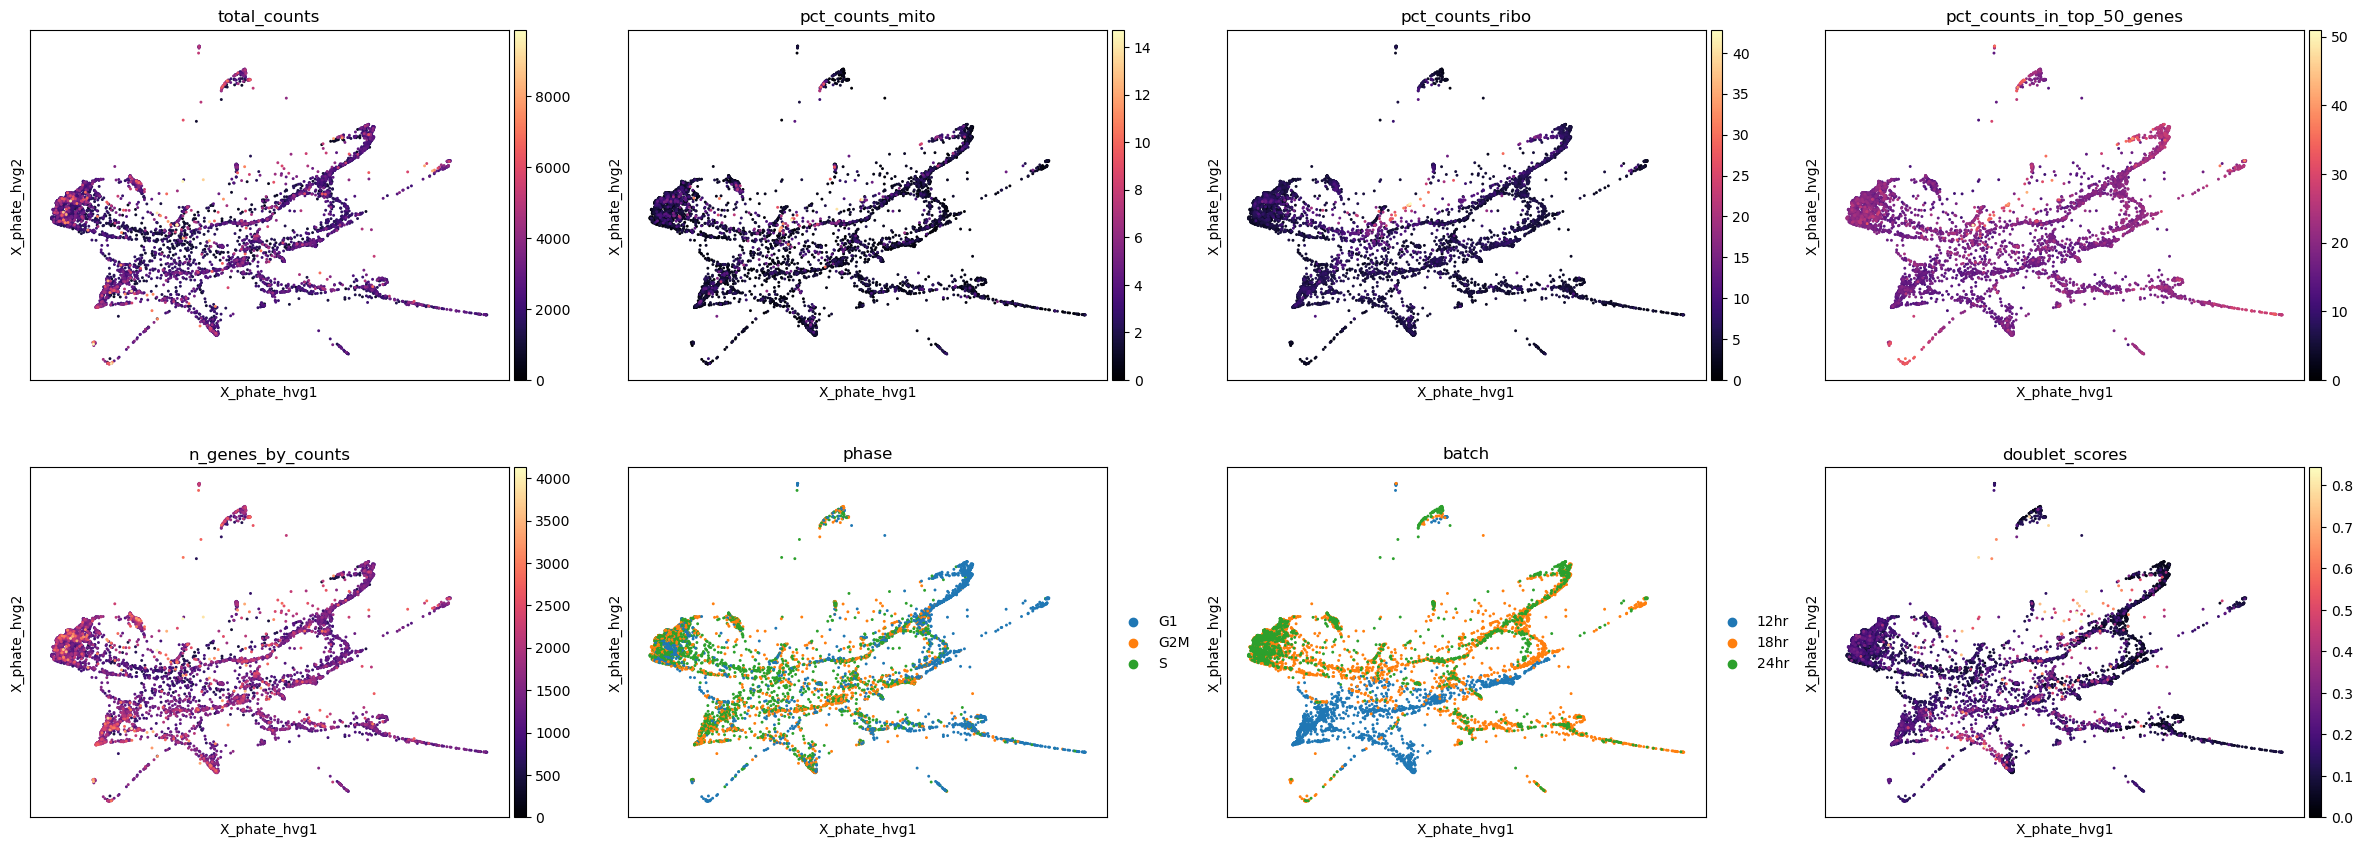

In [19]:
sc.pl.embedding(adata, basis='X_phate_hvg', sort_order=True, vmin=0, color=VOIs, use_raw = False, color_map='magma')


## Add meta data

In [20]:
from degex.adata import (    
    add_human_tfs_from_csv,
    add_mouse_tfs_from_csv
)
import pandas as pd

In [21]:
tf_annotation = pd.read_csv(f'{DATA_DIR}/genes/Danio_rerio_ensembl_tfs.csv', index_col=None, header=0).astype(str)
adata.var['TFs'] = adata.var.Ensembl.isin(tf_annotation.gene_stable_id)

adata = add_human_tfs_from_csv(
    adata, 
    os.path.join(DATA_DIR, 'genes', 'Homo_sapien_ensembl_tfs_v_1.01.csv')
)

adata = add_mouse_tfs_from_csv(
    adata, 
    os.path.join(DATA_DIR, 'genes', 'Mus_musculus_ensembl_tfs.csv')
)

# TFs in any species
adata.var['AnySpecies_TFs'] = adata.var['MouseTFs'] | adata.var['HumanTFs'] | adata.var['TFs']


In [22]:
gene_annotation = pd.read_csv(f'{DATA_DIR}/genes/Gene_annotation.csv', index_col=None, header=0).astype(str)
gene_annotation.index = list(gene_annotation.Ensembl)

In [23]:
# Make a list of marker genes (12hr from Shier lab data)
marker_annotation = pd.read_csv(f'{DATA_DIR}/genes/farrell_boswell_larval_zebrafish_marker_genes_ensembl104.csv', index_col=None, header=0).astype(str)
marker_annotation = pd.merge(marker_annotation, gene_annotation, left_on="gene_stable_id", right_on="Ensembl", how='inner')
marker_annotation['tissue'] = marker_annotation['tissue'].str.replace(' / ','-')
marker_annotation['tissue'] = marker_annotation['tissue'].str.replace('/','-')
marker_annotation['tissue'] = marker_annotation['tissue'].str.replace(' ','-')
marker_annotation.sort_values(by = ['tissue', 'subtissue', 'gene'], ascending = [True, True, True], na_position = 'first', inplace=True)
marker_annotation


tissue           subtissue     gene      gene_stable_id  \
10         Axial-Mesoderm           Notochord  COL2A1A  ENSDARG00000069093   
11         Axial-Mesoderm           Notochord  COL8A1A  ENSDARG00000077403   
15         Axial-Mesoderm           Notochord     NOTO  ENSDARG00000021201   
17         Axial-Mesoderm           Notochord     NTD5  ENSDARG00000040944   
12         Axial-Mesoderm           Notochord   P4HA1B  ENSDARG00000071082   
..                    ...                 ...      ...                 ...   
28  Pre-placodal-ectoderm        Otic placode    PAX2A  ENSDARG00000028148   
82  Pre-placodal-ectoderm        Otic placode    TBX2B  ENSDARG00000006120   
96  Pre-placodal-ectoderm  Trigeminal placode    IRX1A  ENSDARG00000101831   
95  Pre-placodal-ectoderm  Trigeminal placode    KLF17  ENSDARG00000038792   
97  Pre-placodal-ectoderm  Trigeminal placode   P2RX3A  ENSDARG00000010477   

               Ensembl     EntrezID                ZFinID ZFinSymbol  \
10  ENSDARG00000069093     562496.0   ZDB-GENE-980526-192    col2a1a   
11  ENSDARG00000077403     557795.0   ZDB-GENE-070912-274    col8a1a   
15  ENSDARG00000021201      30260.0    ZDB-GENE-990415-75       noto   
17  ENSDARG00000040944     386628.0     ZDB-GENE-031030-7       ntd5   
12  ENSDARG00000071082  100003675.0  ZDB-GENE-030131-4089     p4ha1b   
..                 ...          ...                   ...        ...   
28  ENSDARG00000028148      30425.0     ZDB-GENE-990415-8      pax2a   
82  ENSDARG00000006120      30253.0    ZDB-GENE-990726-27      tbx2b   
96  ENSDARG00000101831     403019.0     ZDB-GENE-040707-1      irx1a   
95  ENSDARG00000038792      65238.0     ZDB-GENE-010129-1      klf17   
97  ENSDARG00000010477      58147.0     ZDB-GENE-000427-3     p2rx3a   

   GeneSymbol                                        Description  \
10    col2a1a  collagen, type II, alpha 1a [Source:ZFIN;Acc:Z...   
11    col8a1a  collagen, type VIII, alpha 1a [Source:ZFIN;Acc...   
15       noto  notochord homeobox [Source:ZFIN;Acc:ZDB-GENE-9...   
17       ntd5  ntl-dependent gene 5 [Source:ZFIN;Acc:ZDB-GENE...   
12     p4ha1b  prolyl 4-hydroxylase, alpha polypeptide I b [S...   
..        ...                                                ...   
28      pax2a         paired box 2a [Source:NCBI gene;Acc:30425]   
82      tbx2b  T-box transcription factor 2b [Source:NCBI gen...   
96      irx1a  iroquois homeobox 1a [Source:ZFIN;Acc:ZDB-GENE...   
95      klf17  Kruppel-like factor 17 [Source:ZFIN;Acc:ZDB-GE...   
97     p2rx3a  purinergic receptor P2X, ligand-gated ion chan...   

           Biotype   HumanEnsemblID HumanGeneSymbol HumanEntrezID  \
10  protein_coding  ENSG00000139219          COL2A1        1280.0   
11  protein_coding              nan             nan           nan   
15  protein_coding  ENSG00000214513            NOTO      344022.0   
17  protein_coding  ENSG00000143278            F13B        2165.0   
12  protein_coding  ENSG00000122884           P4HA1        5033.0   
..             ...              ...             ...           ...   
28  protein_coding  ENSG00000075891            PAX2        5076.0   
82  protein_coding  ENSG00000121068            TBX2        6909.0   
96  protein_coding  ENSG00000170549            IRX1       79192.0   
95  protein_coding  ENSG00000171872           KLF17      128209.0   
97  protein_coding  ENSG00000109991           P2RX3        5024.0   

        MouseEnsemblID MouseGeneSymbol MouseEntrezID  \
10  ENSMUSG00000022483          Col2a1       12824.0   
11                 nan             nan           nan   
15  ENSMUSG00000068302            Noto      384452.0   
17  ENSMUSG00000026368            F13b       14060.0   
12  ENSMUSG00000019916           P4ha1       18451.0   
..                 ...             ...           ...   
28  ENSMUSG00000004231            Pax2       18504.0   
82  ENSMUSG00000000093            Tbx2       21385.0   
96  ENSMUSG00000060969            Irx1       16371.0   
95  ENSMUSG

In [56]:
tissue_types = np.array(sorted(marker_annotation.tissue.unique()))
tissue_types

array(['Axial-Mesoderm', 'Endoderm', 'Fore-mid-brain', 'Hindbrain',
       'Intermediate-Lateral-Mesoderm', 'Neural', 'Non-blastoderm',
       'Non-neural-ectoderm', 'Paraxial-mesoderm',
       'Pre-placodal-ectoderm'], dtype='<U29')

Pre-placodal-ectoderm normalised counts


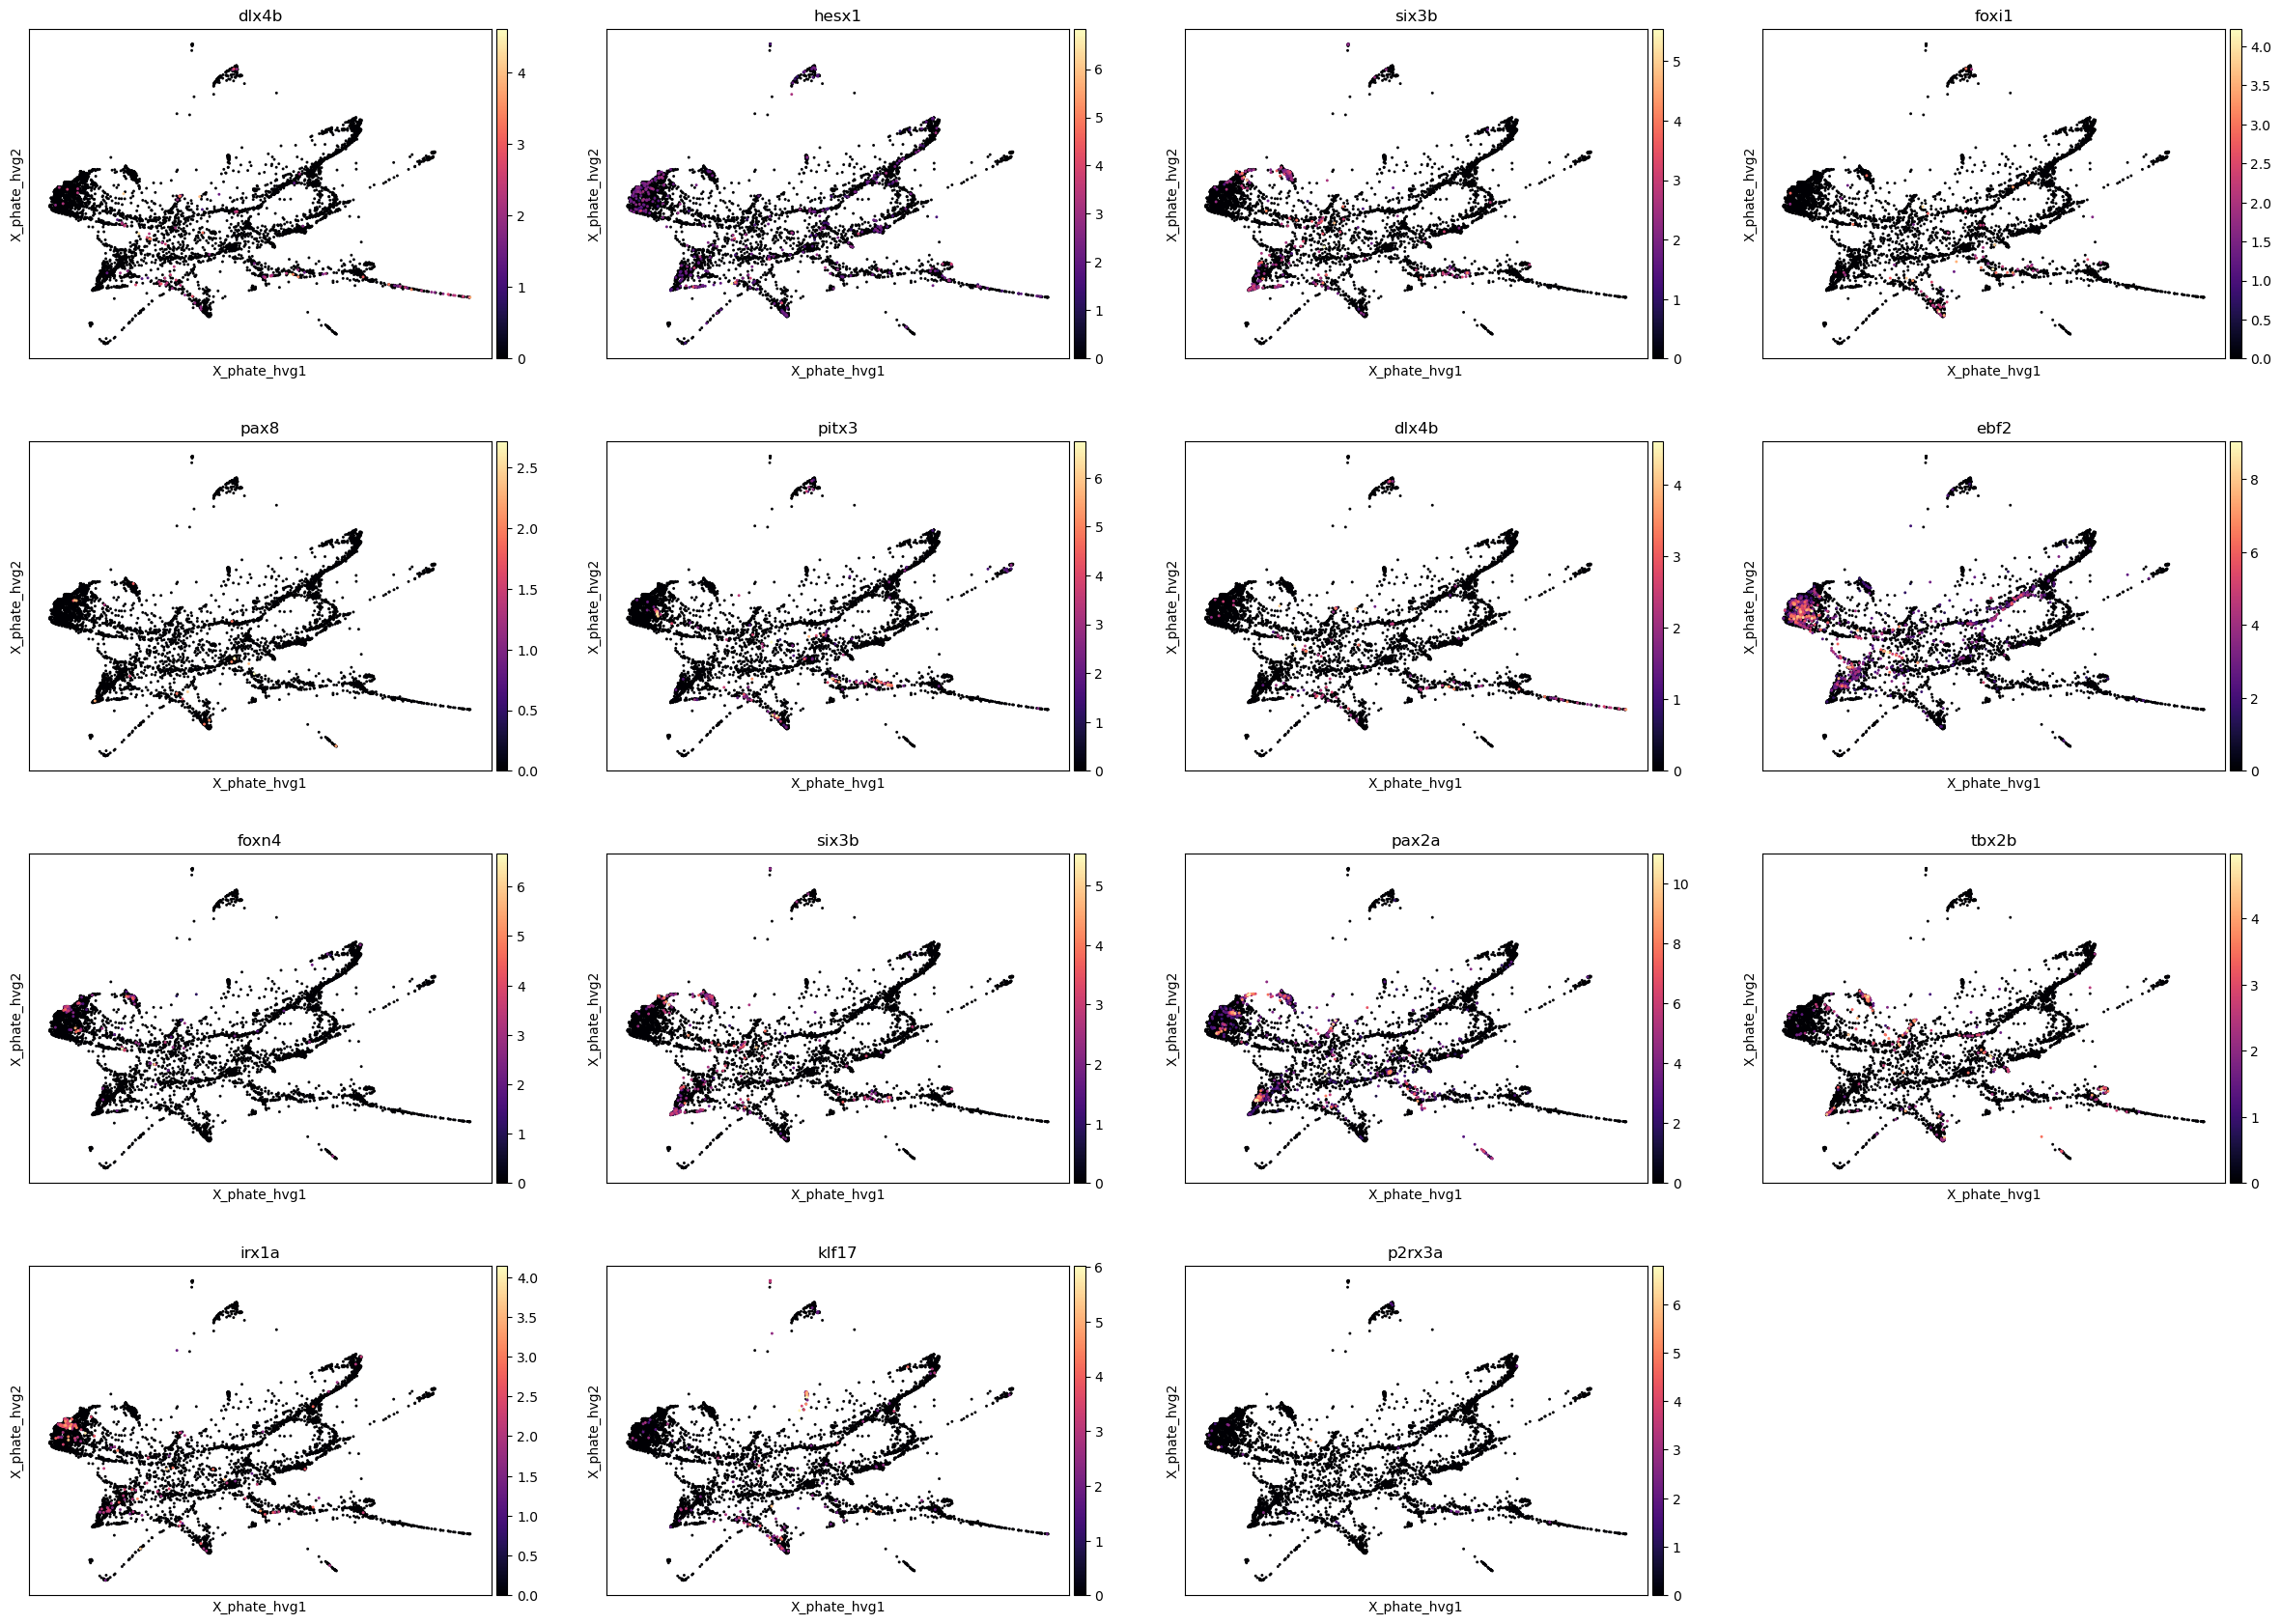

Pre-placodal-ectoderm smoothed counts


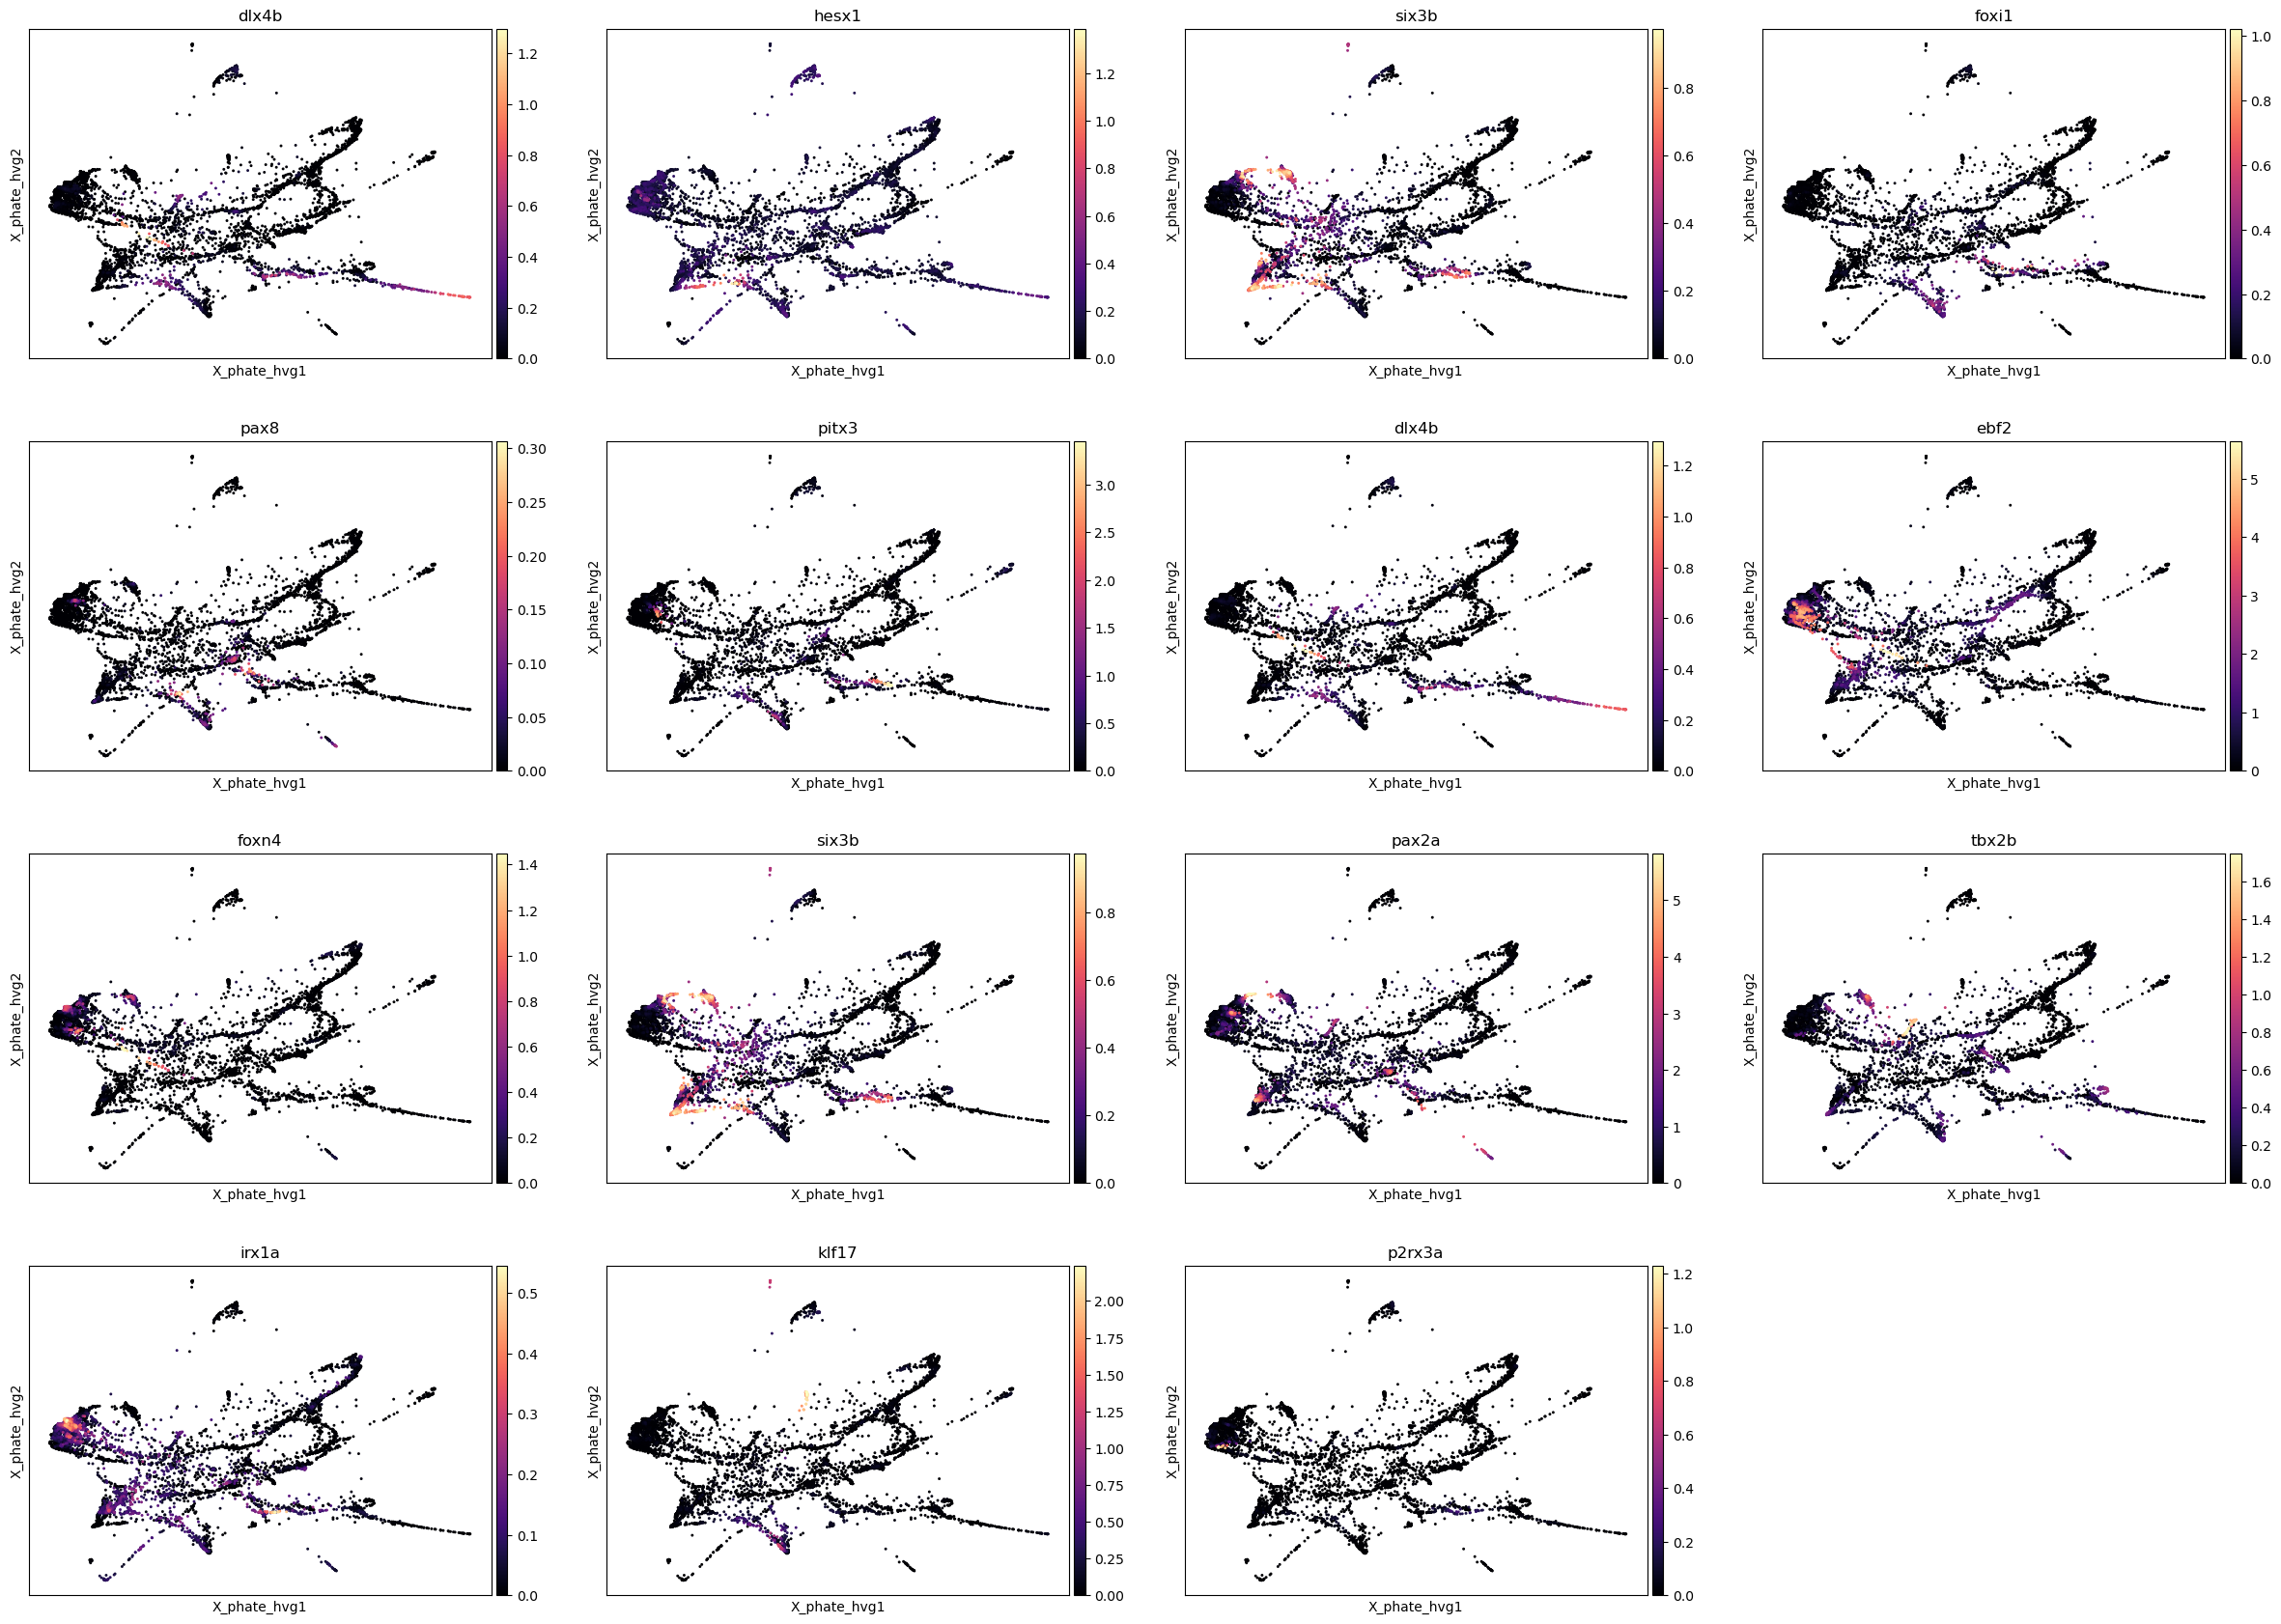

In [36]:
# Visualise marker embedding for each tissue
for tissue in tissue_types:
    
    df_sub = marker_annotation[marker_annotation.tissue == tissue]
    markers = [gene for gene in df_sub.GeneSymbol if gene in adata.var_names]
    
    print(f'{tissue} normalised counts')
    sc.pl.embedding(adata, basis='X_phate_hvg', sort_order=True, vmin=0, color=markers, use_raw = True, color_map='magma')
    print(f'{tissue} smoothed counts')
    sc.pl.embedding(adata, basis='X_phate_hvg', sort_order=True, vmin=0, color=markers, use_raw = False, layer='X_magic', color_map='magma')
    clear_output(wait=True)

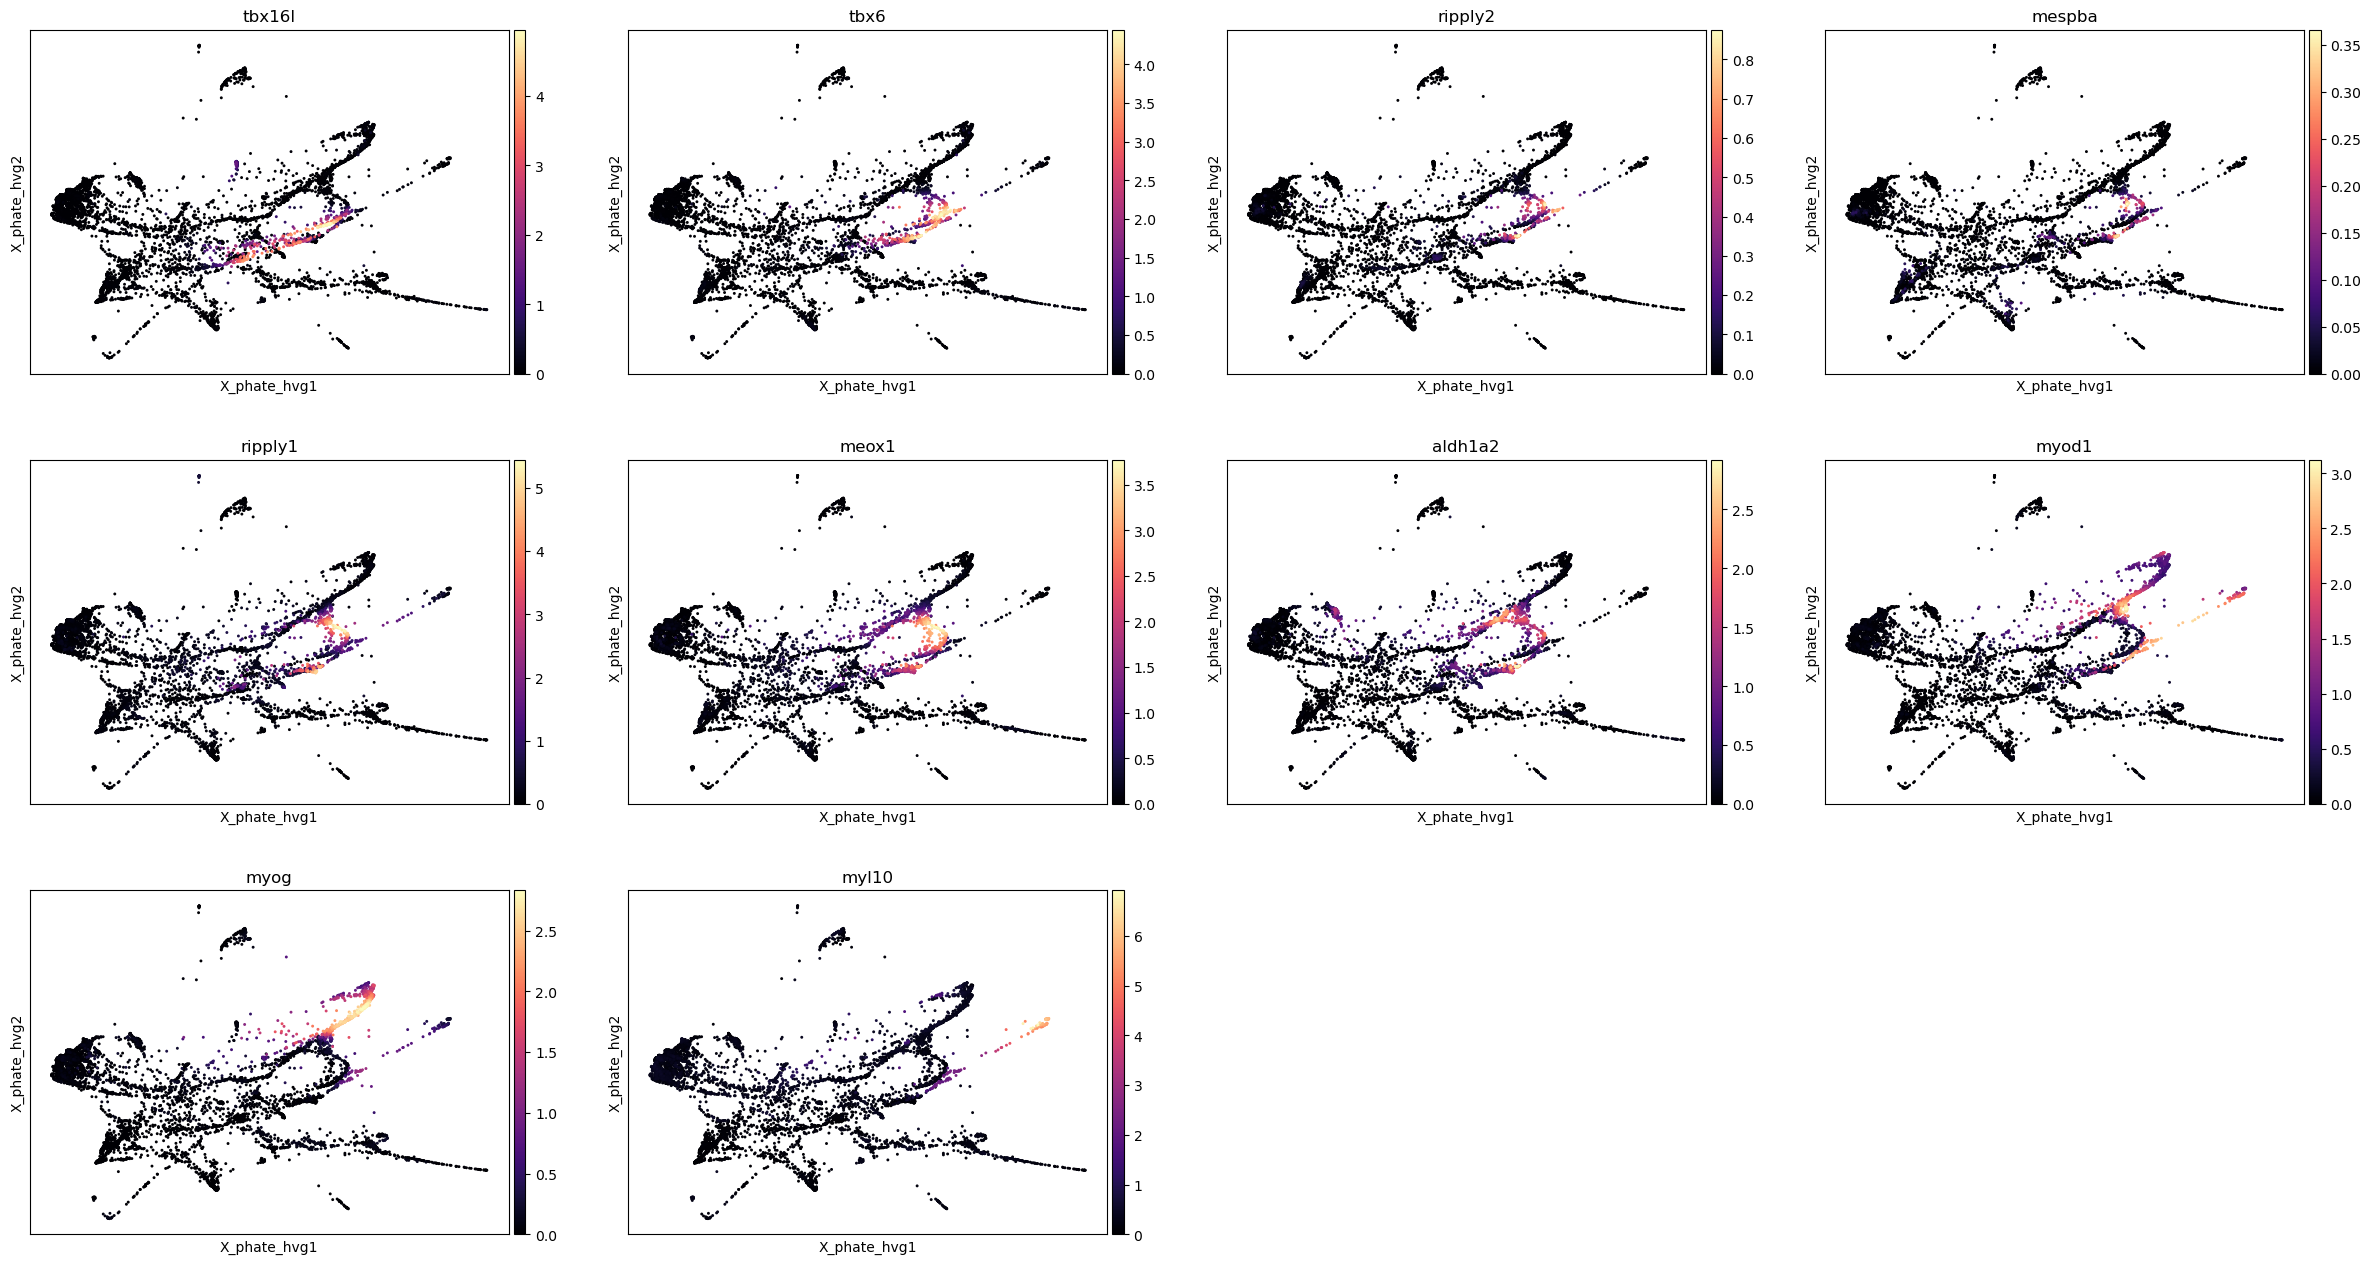

In [37]:
select_markers = ["tbx16l",  "tbx6", "ripply2", "mespba", "ripply1", "meox1", "aldh1a2", "myod1", "myog", "myl10"]
select_markers = [x for x in select_markers if x in adata.var_names]
sc.pl.embedding(adata, basis='X_phate_hvg', sort_order=True, vmin=0, color=select_markers, use_raw = False, layer='X_magic', color_map='magma')

## Z-score markers

In [38]:
from degex.adata import (
    zscore_markers_in_layer, 
    subset_markers
)

### Run over all

In [62]:
def strandardize_tissue_name(s:str):
    s = s.lower().strip()
    s = s.replace('-', '_')
    return s

def abbreviate_tissue(s:str):
    s = s.lower().strip()
    s = list(map(lambda e: e[0].upper(), s.split('-')))
    s = ''.join(s)
    return s

assert len(list(map(abbreviate_tissue, tissue_types))) == len(tissue_types)

In [158]:
tissue_types

array(['Axial-Mesoderm', 'Endoderm', 'Fore-mid-brain', 'Hindbrain',
       'Intermediate-Lateral-Mesoderm', 'Neural', 'Non-blastoderm',
       'Non-neural-ectoderm', 'Paraxial-mesoderm',
       'Pre-placodal-ectoderm'], dtype='<U29')

paraxial_mesoderm PM PM_cells PM_score


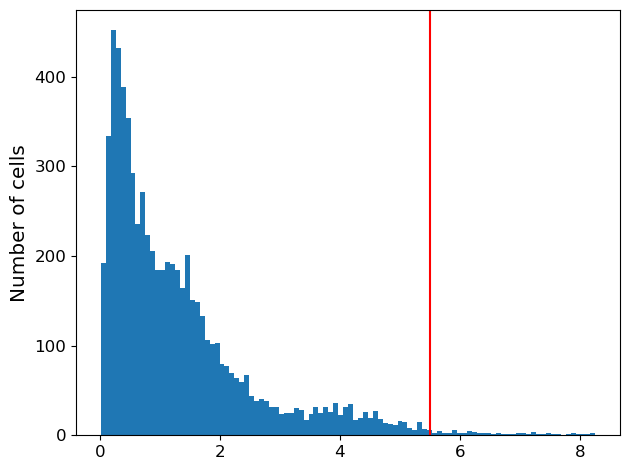

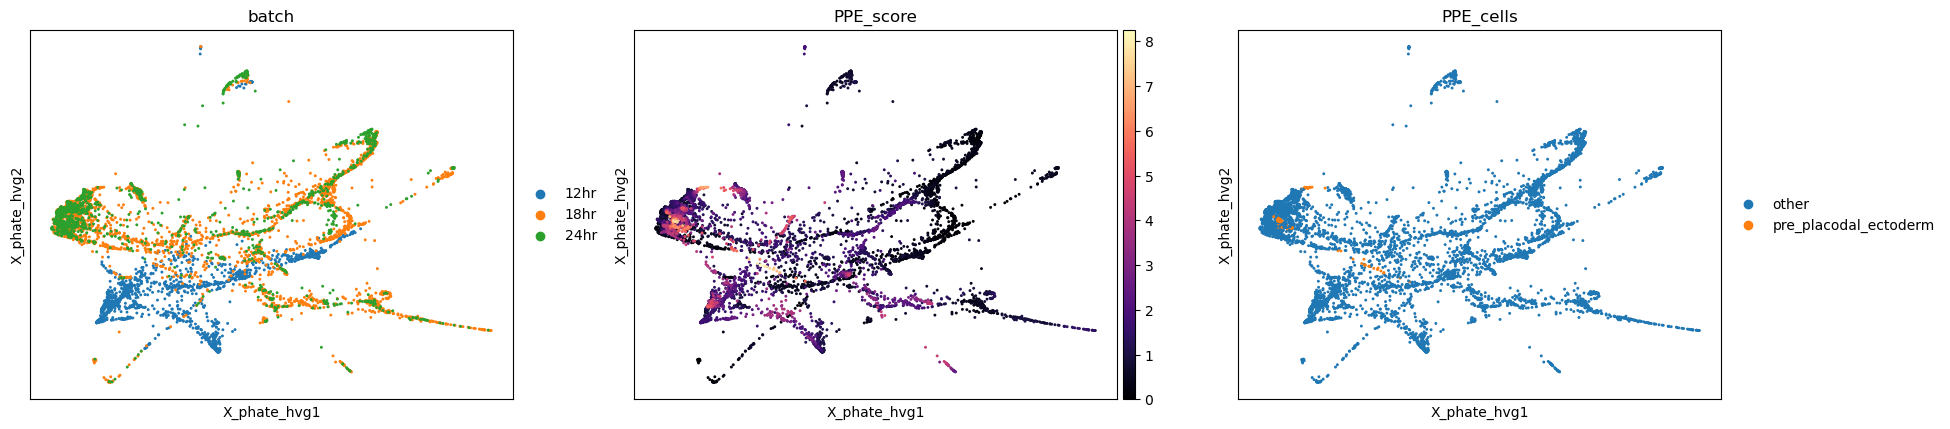

In [159]:
tissue_cutoffs = [
    5, 2.2, 8, 3.7,
    3, 4, 6, 2.2, 2.2,
    5.5
]
for i, tissue in enumerate(tissue_types):
    print(m_name, a_name, c_name, s_name)
    
    m_name = strandardize_tissue_name(tissue)
    a_name = abbreviate_tissue(tissue)
    
    c_name = f'{a_name}_cells'
    s_name = f'{a_name}_score'
    
    
    
    df_sub = marker_annotation[marker_annotation.tissue == tissue]
    markers = [gene for gene in df_sub.GeneSymbol if gene in adata.var_names]
    
    adata = zscore_markers_in_layer(
        adata, 
        markers=markers,
        obs_key=s_name
    )

    # Histogram of PM scores to find min threshold across all cells
    min_score = max(2.2, tissue_cutoffs[i])
    scprep.plot.histogram(adata.obs[s_name], cutoff=min_score)

    adata = subset_markers(
        adata,
        obs_key=c_name,
        score_key=s_name,
        marker_name=m_name,
        lower=min_score
    )
    
    
    sc.pl.embedding(
        adata, basis='X_phate_hvg', sort_order=True, vmin=0, 
        color=['batch', s_name, c_name], 
        use_raw = False, layer='X_magic', color_map='magma'
    )
    clear_output(wait=True)

### Highlight just Paraxial mesoderm

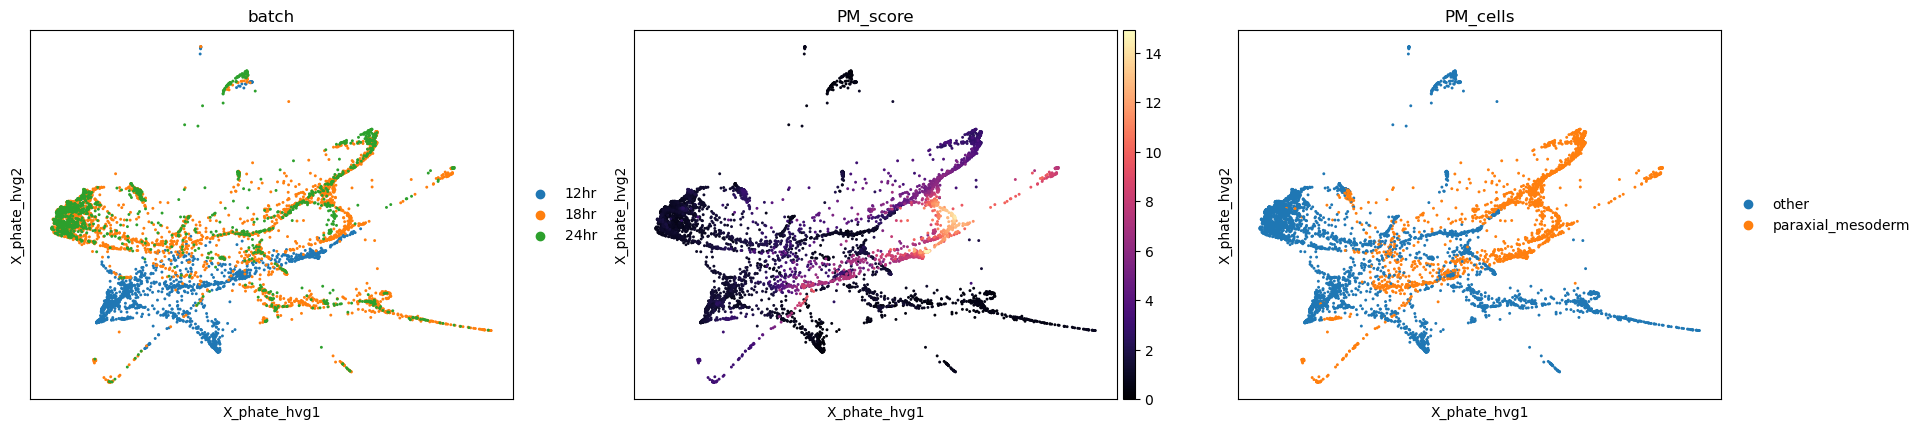

In [160]:
sc.pl.embedding(adata, basis='X_phate_hvg', sort_order=True, vmin=0, color=['batch', 'PM_score', 'PM_cells'], use_raw = False, layer='X_magic', color_map='magma')

In [162]:
(adata.obs.PM_cells == 'paraxial_mesoderm').sum()

2015

## Alternative approach with KNN
**NOTE**: this is to show / motivate _why_ we use z-scoring

In [163]:
import scprep, seaborn as sns, numpy as np
import matplotlib.pyplot as plt

In [164]:
# extract KNNs from graph on 100 PCs
knn_dists, knn_idxs = g_hvg.knn_tree.kneighbors(adata.obsm['X_pca_hvg'])

# df of magic smoothed counts
df_counts = pd.DataFrame(
    adata.layers['X_magic'].todense(), 
    columns=adata.var.index,
    index=adata.obs.index
)

# just columns of marker genes
cell_marker_vals = df_counts.loc[:, select_markers].values

# as a dataframe
df_mean_knn = pd.DataFrame(
    cell_marker_vals[knn_idxs].mean(axis=1),
    index=adata.obs.index,
    columns=select_markers
)

c = df_mean_knn.values.mean(axis=1)

<Axes: >

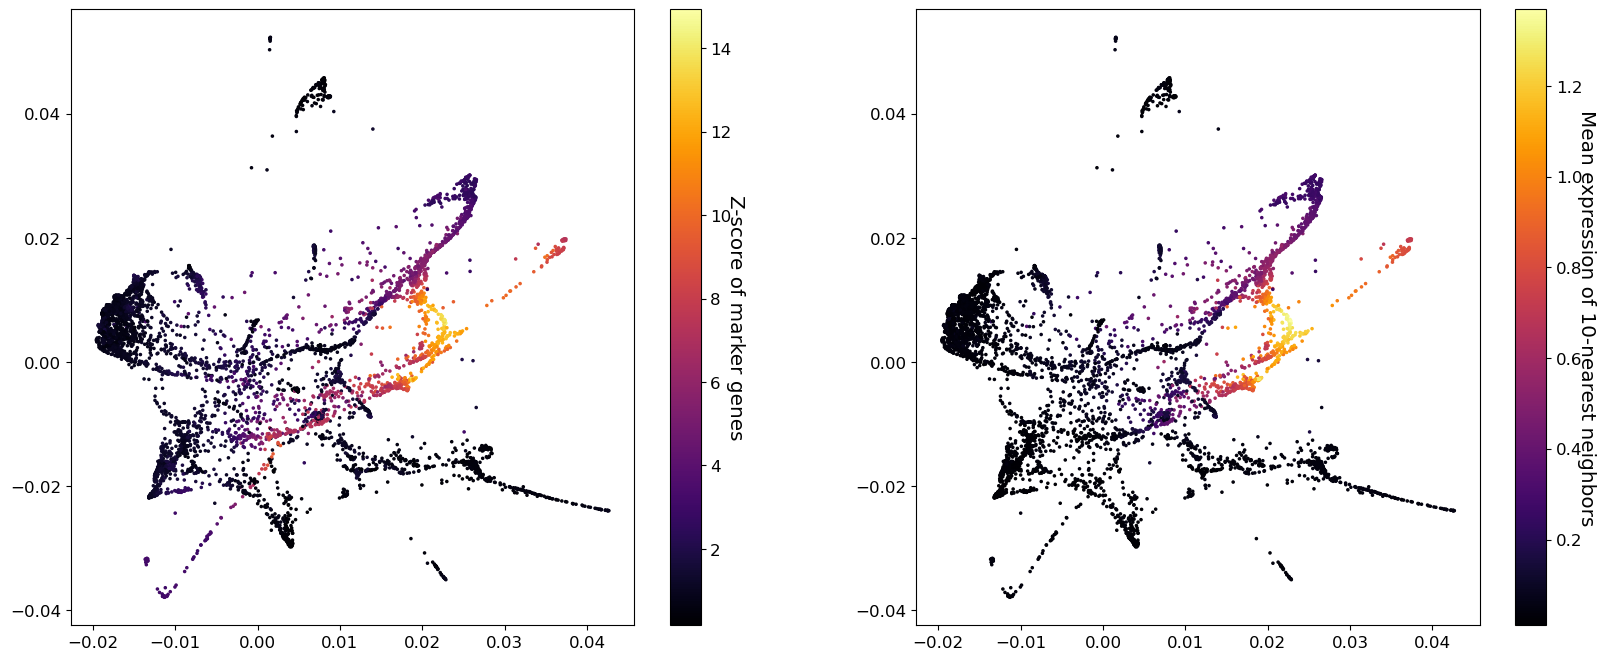

In [165]:
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1,2,1)
scprep.scprep.plot.scatter2d(
    adata.obsm['X_phate_hvg'],
    c=adata.obs.PM_score, ax=ax, legend_title='Z-score of marker genes'
    
)

ax = fig.add_subplot(1,2,2)
scprep.scprep.plot.scatter2d(
    adata.obsm['X_phate_hvg'],
    c=c, ax=ax, legend_title='Mean expression of 10-nearest neighbors'
)

- largest connected component larger than x?
- normalize genes to be densities, 
    + marker gene over cells, each gene should sum to 1 after magic
- mean of all the densities

## Save process adata file

In [70]:
FARNAM_DIR

'/gpfs/gibbs/pi/krishnaswamy_smita/Boswell_Multiome_2023'

In [77]:
SAVE_DIR = os.path.join(FARNAM_DIR, 'processed')
if not os.path.isdir(SAVE_DIR):
    os.makedirs(SAVE_DIR)

In [166]:
adata.write(os.path.join(SAVE_DIR, 'zscored_adata.h5'))

with open(os.path.join(SAVE_DIR, 'g.pkl'), 'wb') as f:
    pickle.dump(g, f)
    
with open(os.path.join(SAVE_DIR, 'g_hvg.pkl'), 'wb') as f:
    pickle.dump(g_hvg, f)

# Redo PHATE to get operator

In [210]:
#| export
import numpy as np
import graphtools
from sklearn.neighbors import NearestNeighbors
from sklearn.base import BaseEstimator, TransformerMixin
import scprep, scipy as sp, phate
class BranchPointPredictor(BaseEstimator, TransformerMixin):
    def __init__(
        self, 
        phate_op: phate.PHATE, # a trained PHATE operator
        extrema_percentile:float = 50, # percentile to mask when calculating extrema
        diffusion_iterations:int=20 # number of iterations to diffuse
    ):
        
        self.phate_op = phate_op
        self.extrema_percentile = extrema_percentile
        self.diffusion_iterations = diffusion_iterations
                      
    def fit(self, X, y=None):
        self.diffuse_dirac_for_end_points()
        self.assign_branches(X)
        self.plot_branchs(X)
        self.plot_branch_classes(X)
        return self
    
    def transform(self, X):
        return self.classes
    

    # NOTE: these two properties are for convenience of the developer
    # and they just expose the underlying PHATE operator values
    @property
    def diff_op(self):
        try:
            return self.phate_op.diff_op
        except AttributeError:
            return None

    @property
    def optimal_t(self):
        try:
            t = self.phate_op.optimal_t
            return t if t is not None else self.phate_op.t
        except AttributeError:
            return None
    

    # NOTE: listing all properties up top for readability
    @property
    def dmap(self):
        '''
        Returns the diffusion map calculated from the diffusion operator
        '''
        try:
            return self._dmap
        except AttributeError:        
            self._calc_dmap()            
            return self._dmap 

    @property
    def n_use(self):
        '''
        The number of eigenvectors in the diffusion map to use
        for downstream analyses
        '''
        try:
            return self._n_use
        except AttributeError:        
            self._calc_num_to_consider()            
            return self._n_use 

    @property
    def most_distinct_points(self):
        '''
        The most distinct points **prior** to downstream analysis.
        These are the extrema.
        '''
        try:
            return self._most_distinct_points
        except AttributeError:        
            self._calc_extrema()          
            return self._most_distinct_points
       
    @property
    def is_landmarked(self):
        '''
        Whether or not the graph in the PHATE operator is a Landmark Graph
        which matters when reconstructing class labels
        '''
        return (
            isinstance(self.phate_op.graph, graphtools.graphs.kNNLandmarkGraph) or
            isinstance(self.phate_op.graph, graphtools.graphs.TraditionalLandmarkGraph)
        )
    
    # NOTE: these two properties are for handling reconstruction from the landmark operator
    # back to the original data space.
    @property
    def pmn(self):
        try:
            return self.phate_op.graph.transitions
        except Exception:        
            return None
        
    @property
    def pnm(self):
        try:
            return self.phate_op.graph._data_transitions()
        except Exception:        
            return None
        
    @property
    def n_rows(self):
        return self.pmn.shape[0] if self.pmn is not None else self.diff_op.shape[0]
    
    @property
    def nn_dist(self):
        '''
        Nearest Neighbor distance matrix calculated on diffusion operator
        '''
        try:
            return self._nn_dist
        except AttributeError:
            self._knn_on_diff_op()
            return self._nn_dist
        
    @property
    def nn_idxs(self):
        '''
        Nearest Neighbor indicies calculated on diffusion operator
        '''
        try:
            return self._nn_idxs
        except AttributeError:
            self._knn_on_diff_op()
            return self._nn_idxs
        
    @property
    def n_nbrs(self):
        try:
            return self._n_nbrs
        except AttributeError:
            self.max_likelihood_pointwise_dimensionality_est()
            return self._n_nbrs
    
    @property
    def nbrs_dim_est(self):
        try:
            return self._nbrs_dim_est
        except AttributeError:
            self.max_likelihood_pointwise_dimensionality_est()
            return self._nbrs_dim_est
    
    @property
    def most_distinct_points_adjusted(self):
        try:
            return self._most_distinct_points_adjusted
        except AttributeError:
            self.max_likelihood_pointwise_dimensionality_est()
            return self._most_distinct_points_adjusted

    @property
    def classes(self):
        '''
        Branch class labels
        '''
        try:
            return self._classes
        except AttributeError:
            self.diffuse_dirac_for_end_points()
            return self._classes
        
    @property
    def branch_classes(self):
        try:
            return self._branch_classes
        except AttributeError:
            self.assign_branches(self.phate_op.X)
            return self._branch_classes

    @property
    def branch_points(self):
        try:
            return self._branch_points
        except AttributeError:
            self.diffuse_dirac_for_end_points()
            return self._branch_points
    
    # NOTE: sets property dmap
    def _calc_dmap(self, t=None):
        if t is None:
            t = self.optimal_t

        evals, evecs = np.linalg.eig(self.diff_op)
                
        # sort eigenvectors in descending order
        idx = np.abs(evals).argsort()[::-1]
        evals = evals[idx]
        evecs = evecs[:, idx]

        # do diffusion        
        evals = np.power(evals, self.optimal_t)
        evecs = evecs.dot(np.diag(evals))

        self.evals = evals
        self.evecs = evecs
        self._dmap = evecs   
        return evecs

    # NOTE: sets property n_use      
    def _calc_num_to_consider(self):
        dmap = self.dmap
        evals = self.evals
        
        # Number of eigenvectors (~ dimensions) to consider.
        dmap_diff = evals - np.roll(evals, 1)
        
        n_evecs = 1
        # Increase the number of eigenvectors until 
        while (dmap_diff[n_evecs + 1] > 2 * dmap_diff[n_evecs]):
            n_evecs += 1
        
        self._n_use = n_evecs
        return n_evecs
    
    # NOTE: sets property most_distinct_points
    def _calc_extrema(self):
        # NOTE: these functions are equivalent, but
        # v2 is used in latest version on GitHub and
        # although v1 looks cleaner
        return self.__calc_extrema_v2()
        return self.__calc_extrema_v1()
    
    def __calc_extrema_v1(self):
        dmap = self.dmap

        # Ignore first (trivial) eigenvector
        dmap = dmap[:, 1:].copy()

        # Mask lower 50% abs val
        lower_half_abs = np.percentile(np.abs(dmap), self.extrema_percentile)
        dmap[np.abs(dmap) < lower_half_abs] = 0

        max_idxs = dmap.argmax(axis=0)
        min_idxs = dmap.argmin(axis=0)
        extrema_idxs = np.unique(np.hstack((max_idxs, min_idxs)))
        self._most_distinct_points = extrema_idxs
        return extrema_idxs

    def __calc_extrema_v2(self):
        # Find the extremas (min and max) of the considered eigenvectors.
        # Keep them in the order of the eigenvalues by weaving min and max values.
        # min_eigs = phate_op_eigvecs[:,1:n_eigvecs+1].argmin(0)
        # max_eigs = phate_op_eigvecs[:,1:n_eigvecs+1].argmax(0)
        # combined_eigs = np.empty((min_eigs.size + max_eigs.size,), dtype=min_eigs.dtype)
        # combined_eigs[0::2] = min_eigs
        # combined_eigs[1::2] = max_eigs

        # Remove duplicates.

        # for e in combined_eigs:
        #     if e not in most_distinct_points:
        #         most_distinct_points.append(e)

        n_consider = self.n_use
        dmap = self.dmap

        most_distinct_points = []

        # Always skip the first trivial eigenvector
        for i in np.arange(n_consider):
            cur_eigvec = np.copy(dmap[:,i+1])
            # Sometimes the eigvectors are skewed towards one side (much more possitive values than negative 
            # values and vice versa). This part ensures only the extrema on the more significant side is taken.            
            lower_half_abs = np.percentile(np.abs(cur_eigvec), self.extrema_percentile)
            cur_eigvec[np.abs(cur_eigvec) < lower_half_abs] = 0

            max_eig = np.argmax(cur_eigvec)
            min_eig = np.argmin(cur_eigvec)

            if cur_eigvec[max_eig] > 0 and max_eig not in most_distinct_points:
                most_distinct_points.append(max_eig)
            
            if cur_eigvec[min_eig] < 0 and min_eig not in most_distinct_points:
                most_distinct_points.append(min_eig)

        most_distinct_points = np.array(most_distinct_points)
        self._most_distinct_points = most_distinct_points
        return most_distinct_points        

        
    def _knn_on_diff_op(self):
        # NOTE: using KNN on diff_map is not invertable
        # i.e. need to revert landmark graph here!
        dmap = self.dmap

        #######################
        # INTRINSIC DIMENSION #
        #######################

        # Based on maxLikPointwiseDimEst() of this R package.
        # https://cran.r-project.org/web/packages/intrinsicDimension/README.html

        # Up to 100 dimensions of diffusion maps, 
        # raised to the same power as tdetermined by PHATE.
        dm_dims = min(self.diff_op.shape[1], 100) # NOTE: oroginaly was data.shape[1]
        diff_map = dmap[:,:dm_dims]
        # diff_map = diff_map.dot(np.diag(np.power(phate_op_eigvals[:dm_dims], 11)))
        if self.is_landmarked:
            diff_map = self.phate_op.graph.interpolate(diff_map)
    
        # Rank all neighbors in diffusion map coordinates.
        nbrs = NearestNeighbors(
            # n_neighbors=dm_dims,
            n_neighbors=diff_map.shape[0],
            algorithm='ball_tree'
        ).fit(diff_map)

        nn_distances, nn_indices = nbrs.kneighbors(diff_map)
        nn_distances = nn_distances[:, 1:]
        nn_indices = nn_indices[:, 1:]
        self._nn_dist = nn_distances
        self._nn_idxs = nn_indices
        return nn_distances, nn_indices

    def max_likelihood_pointwise_dimensionality_est(self):
        n_rows = self.n_rows
        nn_dist = self.nn_dist
        nn_idxs = self.nn_idxs 
        most_distinct_points = np.copy(self.most_distinct_points)

        # Maximum Likelihood pointwise dimensionality estimation
        # Hill (1975), Levina and Bickel (2005)
        row_max = np.max(nn_dist, axis=1)
        row_max = row_max.reshape(len(row_max), 1)
        dim_est = np.sum(np.log(row_max / nn_dist), axis=1)

        # Calculate the average dim_est of local neighborhood.
        n_nbrs = min(n_rows // 20, 100)
        nbrs_dim_est = np.average(dim_est[nn_idxs[:, :n_nbrs]], axis=1)
        # nbrs_dim_est = phate_op.graph.interpolate(nbrs_dim_est)

        # Calculate ranking of neighborhood dim_est, from low to high
        temp = nbrs_dim_est.argsort()
        nbrs_dim_est_ranks = np.empty_like(temp)
        nbrs_dim_est_ranks[temp] = np.arange(len(nbrs_dim_est))

        # Make sure that all distinct points are end points (low dim_est), 
        # not branch point (high dim_est)
        low_dim_est_mask = nbrs_dim_est_ranks[most_distinct_points] < n_rows // 2
        most_distinct_points = most_distinct_points[low_dim_est_mask]

        self._most_distinct_points_adjusted = most_distinct_points
        self._n_nbrs = n_nbrs
        self._nbrs_dim_est = nbrs_dim_est
        return n_nbrs, nbrs_dim_est
    
    def diffuse_dirac_for_end_points(self):        
        n_nbrs = self.n_nbrs        
        nbrs_dim_est = self.nbrs_dim_est
        # NOTE: use adjusted distinct points from max_likelihood_pointwise_dimensionality_est
        most_distinct_points = self.most_distinct_points_adjusted

        ##################################
        # DIFFUSING DIRAC FOR END POINTS #
        ##################################
        pnm = self.pnm
        pmn = self.pmn
        opt_t = self.optimal_t
        nn_idxs = self.nn_idxs        
        n_rows = self.n_rows

        branch_points = []
        classes = np.zeros(n_rows, dtype="int32") # NOTE: original was data
        classes_value = np.repeat(-float('inf'), n_rows)
        for end_point_index in np.arange(most_distinct_points.size):
            cur_end_point = most_distinct_points[end_point_index]
                        
            if self.is_landmarked:
                undo_diff = (pmn @ self.diff_op @ pnm)
                diff_op_t = np.linalg.matrix_power(undo_diff, opt_t)
            else:
                diff_op_t = np.linalg.matrix_power(self.diff_op, opt_t)            

            branch_point_dim_est_avg_cache = -float('inf')

            for it in range(self.diffusion_iterations):
                branch_from_end_point = diff_op_t[:, cur_end_point]

                branch_max = np.max(branch_from_end_point)
                branch_min = np.min(branch_from_end_point)
                
                branch_threshold = branch_min + (branch_max - branch_min) * 0.1
                
                deviation_from_branch_threshold = branch_from_end_point - branch_threshold
                deviation_from_branch_threshold[deviation_from_branch_threshold < 0] = float('inf')

                cur_branch_point = deviation_from_branch_threshold.argmin()
                potential_branch_points = np.argpartition(deviation_from_branch_threshold, 20)[:20]
                
                branch_point_dim_est_avg = np.average(nbrs_dim_est[potential_branch_points])
                if (branch_point_dim_est_avg < branch_point_dim_est_avg_cache):
                    break
                branch_point_dim_est_avg_cache = branch_point_dim_est_avg
                                
                if self.is_landmarked:                                
                    undo_diff = (pmn @ self.diff_op @ pnm)
                    diff_op_t = diff_op_t.dot(undo_diff)
                else:
                    diff_op_t = diff_op_t.dot(self.diff_op)

            branch_points.append(cur_branch_point)
            on_branch_mask = diff_op_t[:, cur_end_point] > branch_threshold
            color = diff_op_t[:, cur_end_point]

            on_branch_mask[color < classes_value] = 0

            color[np.logical_not(on_branch_mask)] = -np.max(color)

            classes_value[on_branch_mask] = color[on_branch_mask]
            classes[on_branch_mask] = end_point_index + 1

        #####################
        # REMOVE DUPLICATES #
        #####################
        # We want to remove branch points that are too close together.
        branch_points = np.array(branch_points)
        if len(branch_points) == 0:
            branch_points = np.array([True for e in nn_idxs])
            
        branch_point_nbrs = nn_idxs[branch_points, :n_nbrs]
        branch_point_pairs_mask = np.isin(branch_point_nbrs, branch_points)
        center_branch_point = branch_points[np.where(branch_point_pairs_mask)[0]]
        neighbor_branch_point = branch_point_nbrs[branch_point_pairs_mask]
        branch_point_pairs = list(zip(center_branch_point, neighbor_branch_point))

        # For each pair of branch_points, keep only the one with higher eigenvalue.
        # (mdb_pairs, by construction, is sorted by decreasing eigenvalue corresponding 
        # to the first point of each pair.)
        points_to_exclude = []
        for pair in branch_point_pairs:
            if pair[0] not in points_to_exclude:
                points_to_exclude.append(pair[1])

        branch_points = np.delete(
            branch_points, 
            np.argwhere(np.isin(branch_points, points_to_exclude))
        )
        self._classes = classes
        self._branch_points = branch_points
        return branch_points

    def assign_branches(self, emb):
        ###################
        # ASSIGN BRANCHES #
        ###################
        dmap = self.dmap
        most_distinct_points = self.most_distinct_points_adjusted

        # Find coordinates between every point and every MDP.
        all_dm_coords = dmap
        if self.is_landmarked:
            all_dm_coords = (self.pmn @ self.dmap @ self.pnm)
        mdp_dm_coords = all_dm_coords[most_distinct_points,:]
        pairwise_dist = sp.spatial.distance.cdist(all_dm_coords, mdp_dm_coords)

        # For every point, rank MDPs by increasing distance.
        s = np.argsort(pairwise_dist, axis=1)
        i = np.arange(pairwise_dist.shape[0]).reshape(-1, 1)
        j = np.arange(pairwise_dist.shape[1])
        
        mdp_ranking = np.empty_like(pairwise_dist, dtype=int)
        mdp_ranking[i, s] = j + 1

        # Assign every point to the branch between its two most highly ranked MDPs.
        mdp_1 = np.argwhere(mdp_ranking==1)[:,1] + 1
        mdp_2 = np.argwhere(mdp_ranking==2)[:,1] + 1
        
        branch_classes = list(zip(mdp_1, mdp_2))
        branch_classes = [str(sorted(branch_class)) for branch_class in branch_classes]
        if len(branch_classes) == 0:
            branch_classes = np.array([0 for e in range(self.n_rows)])
        
        self._branch_classes = branch_classes 

    def plot_branchs(self, emb):
        most_distinct_points = self.most_distinct_points_adjusted
        branch_points = self.branch_points
        # Plot by class with end points and branch points
        classes = self.classes        
        ax = scprep.plot.scatter2d(emb, c=classes)
        plot_numbers = np.repeat("", emb.shape[0])
        plot_numbers[most_distinct_points] = np.arange(most_distinct_points.shape[0]) + 1
        plot_numbers[branch_points] = "*"
        bbox_props = dict(boxstyle="circle,pad=0.3", fc="w", ec="r", lw=2)
        
        for i, txt in enumerate(plot_numbers):
            ax.annotate(txt, (emb[i][0], emb[i][1]), size=15, bbox=bbox_props)

    def plot_branch_classes(self, emb):
        branch_classes = self.branch_classes
        most_distinct_points = self.most_distinct_points_adjusted

        ax = scprep.plot.scatter2d(emb, c=branch_classes)
        
        plot_numbers = np.repeat("", emb.shape[0])
        plot_numbers[most_distinct_points] = np.arange(most_distinct_points.shape[0]) + 1
        bbox_props = dict(boxstyle="circle,pad=0.3", fc="w", ec="r", lw=2)

        # sys.stdout = open('trash', 'w')
        for i, txt in enumerate(plot_numbers):
            ax.annotate(txt, (emb[i][0], emb[i][1]), size=15, bbox=bbox_props)   
        

# %% ../nbs/06_branches.ipynb 5
def hacky_branch_point_prediction(
    emb,
    nearest_n=200,
    farest_n=5,    
    percentile=99,
    nearby_filter=None,
    clusters=None,
    toggle=True
):
    # pairwise distances in embedding space
    dist_mat = sp.spatial.distance.cdist(emb, emb)

    max_perc = 100
    cur_perc = max_perc - percentile

    # row is point we are looking at, cols are indicies of __furtherst__ neighbors first
    neigh_dist_sorted = dist_mat.argsort(axis=1)
    
    # row is point we are looking at, cols are indicies of __closest__ neighbors first
    neigh_dist_sorted = neigh_dist_sorted[:, ::-1]    
    if toggle:
        # NOTE: toggle = False --> farest (farest_n) of closest (nearest_n) neighbors
        # NOTE: toggle = True --> closest (farest_n) of farest (nearest_n) neighbors
        # we go back to taking the closest of the furthest data
        neigh_dist_sorted = neigh_dist_sorted[:, ::-1]    
    
    # n nearest neighbors
    near = neigh_dist_sorted[:, :nearest_n]
    
    # n nearest sorted to be furthest first
    near = near[:, ::-1]
    # n farest
    far = near[:, :farest_n]

    dist_mat_of_farest_nearby = dist_mat.take(far[far])
    mean_dist_of_farest_nearby = dist_mat_of_farest_nearby.mean(axis=1)
    stds = np.std(mean_dist_of_farest_nearby, axis=1)

    where_above = stds > np.percentile(stds, percentile)

    branch_point_guesses = np.where(where_above == True)[0]
    if nearby_filter is not None:
        keep = []
        ignore = []
        for ip, pnt in enumerate(branch_point_guesses):
            for ont in branch_point_guesses[ip+1:]:      
                
                if dist_mat[pnt, ont] < nearby_filter:
                    ignore.append(ont)
                    continue        
                    
                if pnt in keep:
                    continue
                if pnt in ignore:
                    continue
                keep.append(pnt)
        branch_point_guesses = keep


    if clusters is None:
        clusters = ['unknown' for e in emb]
    
    ax = scprep.plot.scatter2d(emb, c=clusters)    
    for i, node in enumerate(branch_point_guesses):
        coord = branch_point_guesses[i]
        ax.annotate(node, (emb[coord][0], emb[coord][1]), size=15)
    return branch_point_guesses

In [168]:
full_phate_op = phate.PHATE(n_components=3, t=70)
adata_ph = full_phate_op.fit_transform(g_hvg)

Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 6794 observations.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.01 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.35 seconds.
    Calculating KMeans...
    Calculated KMeans in 1.67 seconds.
  Calculated landmark operator in 2.84 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.26 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 23.71 seconds.
Calculated PHATE in 26.82 seconds.


In [169]:
bpp_full = BranchPointPredictor(full_phate_op)

BranchPointPredictor(phate_op=PHATE(n_components=3, t=70))

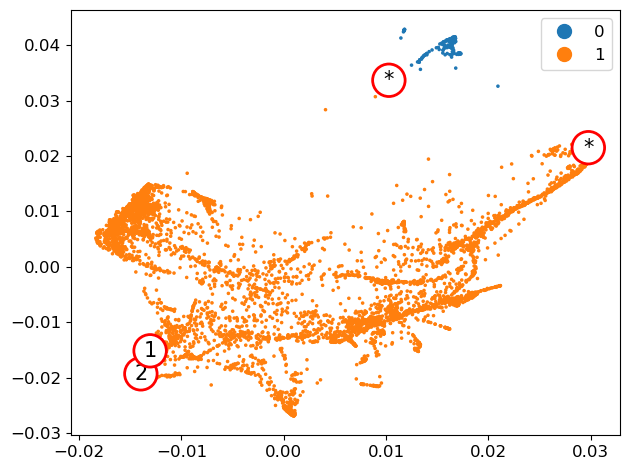

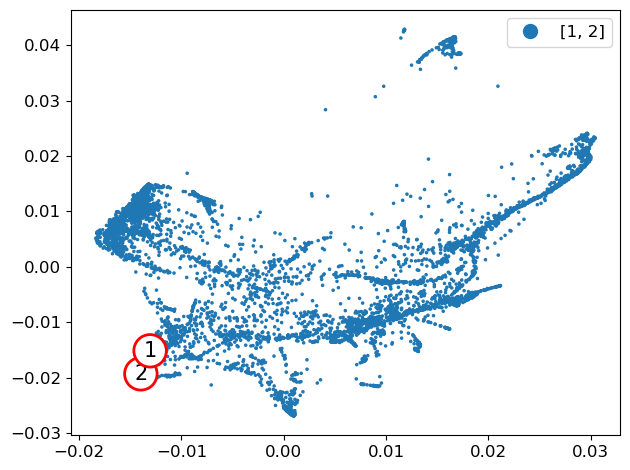

In [170]:
bpp_full.fit(adata_ph)

# Subset Paraxial Mesoderm cells

In [171]:
adata_pm = adata[adata.obs.PM_cells == 'paraxial_mesoderm']

<Axes: >

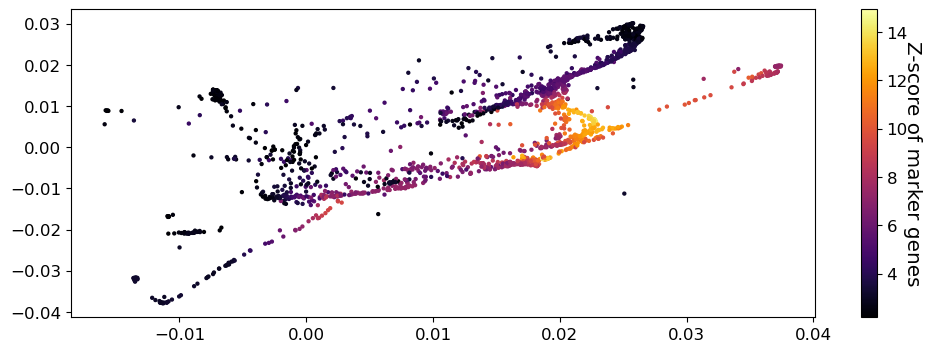

In [172]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1,1,1)
scprep.scprep.plot.scatter2d(
    adata_pm.obsm['X_phate_hvg'],
    c=adata_pm.obs.PM_score, ax=ax, legend_title='Z-score of marker genes'    
)

In [173]:
from degex.branches import BranchPointPredictor

In [174]:
import phate

In [176]:
phate_op = phate.PHATE(n_components=3)
adata_pm_ph = phate_op.fit_transform(adata_pm.X)

Calculating PHATE...
  Running PHATE on 2015 observations and 21780 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.40 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.42 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 1.84 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.09 seconds.
    Calculating KMeans...
    Calculated KMeans in 0.80 seconds.
  Calculated landmark operator in 1.49 seconds.
  Calculating optimal t...
    Automatically selected t = 19
  Calculated optimal t in 0.53 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.09 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 46.66 seconds.
Calculated PHATE in 50.61 seconds.


In [177]:
df_phate = pd.DataFrame(
    adata_pm_ph,
    columns=[f'p{i}' for i in range(1, 4)],
    index=adata_pm.obs.index
)

df_phate.loc[:, 'score'] = adata_pm.obs.PM_score
df_phate.head()

p1        p2        p3     score
AAACGTACACTAAATC-1_0 -0.023269  0.003949 -0.003015  7.215949
AAAGCACCAATGAATG-1_0 -0.022065  0.001760 -0.009629  8.070358
AAAGCACCAGCTCATA-1_0 -0.020022  0.000018 -0.006148  5.987228
AAAGCCCGTTACAAAC-1_0 -0.017742  0.003337 -0.007951  3.725177
AAAGCCCGTTGCGGAT-1_0 -0.013951 -0.003066 -0.010160  3.782695

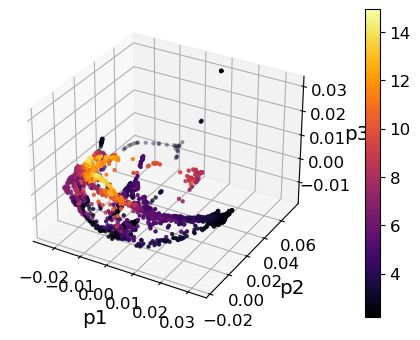

In [178]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1,1,1, projection='3d')
# sns.scatterplot(df_phate, x='p1', y='p2', hue='score', ax=ax)
scprep.plot.scatter3d(df_phate, c=df_phate.score, ax=ax)
sns.despine(trim=True, left=True, bottom=True, fig=fig, ax=ax)

In [180]:
p1 = df_phate.p1
root_loc = np.where(p1 == np.max(p1))[0][0]

adata_pm.uns['iroot'] = root_loc

In [181]:
sc.pp.neighbors(adata_pm)
sc.tl.diffmap(adata_pm)
sc.tl.dpt(adata_pm)

In [183]:
pseudotime = (adata_pm.obs['dpt_pseudotime']*10).astype(int)
np.unique(pseudotime, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([247, 120, 188, 444, 717, 196,  33,   6,  36,  27,   1]))

readjust time labels as needed

In [184]:
ptime = pseudotime.copy()

# remap = [
#     (1, [1, 2, 3]),
#     (2, [4]),
#     (3, [4]),
#     (4, [6, 7, 9, 10]),
# ]

# for new_t, old_ts in remap:
#     for old_t in list(old_ts):
#         ptime[ptime == old_t] = new_t 
    
# np.unique(ptime, return_counts=True)

<Axes: xlabel='p1', ylabel='p2'>

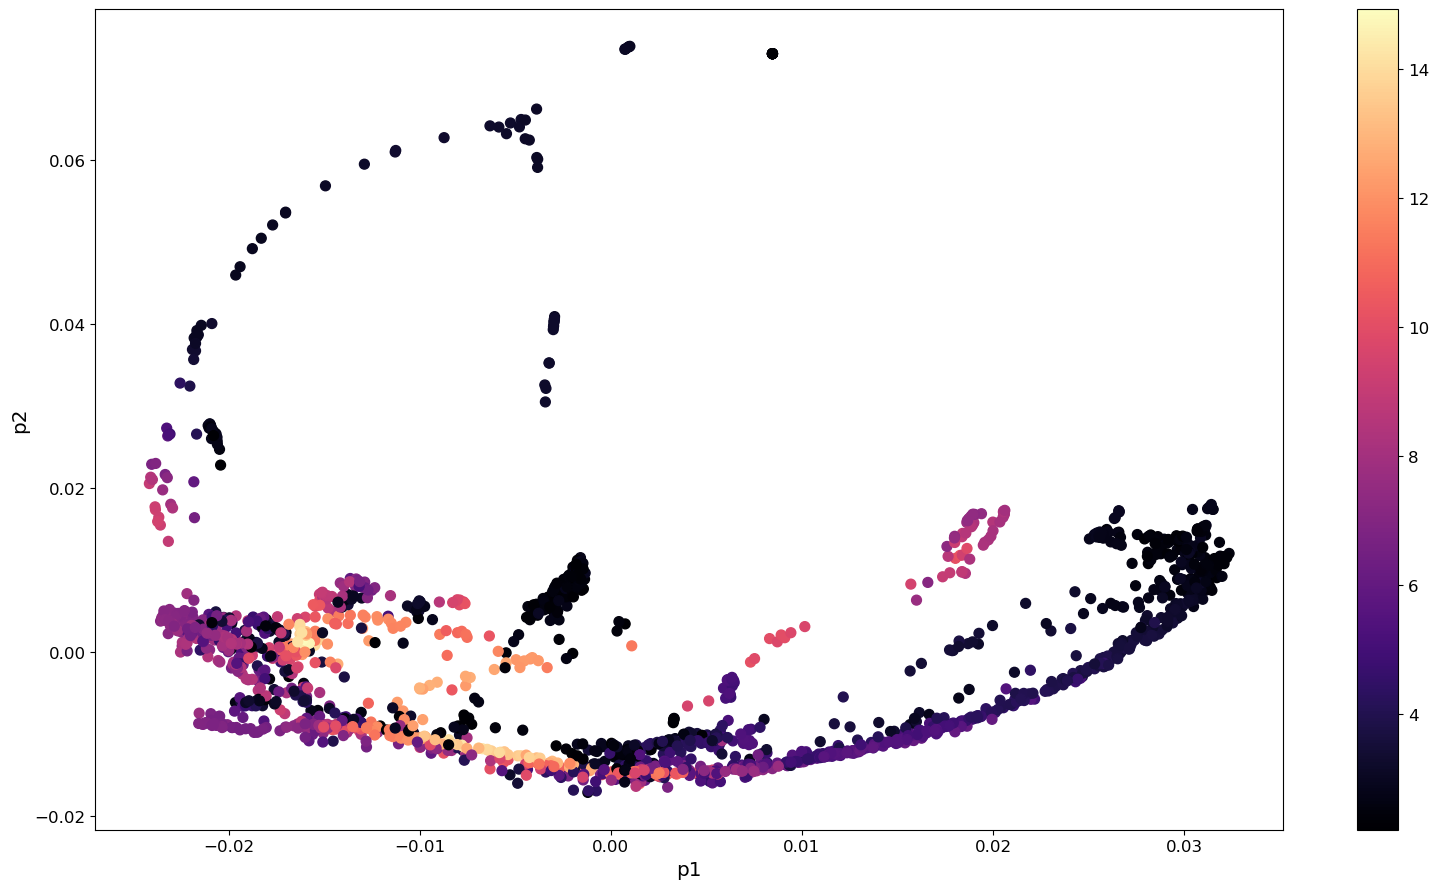

In [232]:
scprep.plot.scatter2d(
    df_phate, 
    c=df_phate.score, 
    s=50,
    figsize=(16, 9), cmap='magma',
)

In [ ]:
df_counts = pd.DataFrame(
    np.array(adata_pm.X.todense()),
    columns=adata_pm.var.index,
    index=adata_pm.obs.index
)
df_counts.head()
df_counts.loc[:, 'samples'] = ptime
df_phate.loc[:, 'samples'] = ptime

In [155]:
pca_loadings = phate_op.graph.data_nu
pca_components = phate_op.graph.data_pca.components_

In [157]:
df = pd.DataFrame(
    pca_loadings, columns=[f'd{i}' for i in range(1, phate_op.n_pca + 1)],
)
df.loc[:, 'samples'] = ptime
df.head()

d1         d2         d3         d4         d5         d6  \
0  60.925438  34.289410  -2.806943 -11.628478  -6.020525  -1.874736   
1  52.650082  -5.180115  -2.722659 -19.180065  15.170686 -10.739076   
2  59.981613   5.266251 -24.348139  -4.040826  -0.737652   1.755197   
3  63.212154 -10.307951  -9.094031 -18.507153   8.330462  10.446510   
4  67.051682 -10.265097 -14.191419 -12.793985  17.143356  -1.029837   

          d7         d8        d9       d10  ...       d92        d93  \
0   4.086803   6.027245 -4.095379  1.404148  ... -5.529953  -3.911498   
1  -0.155143  12.472938  2.420816  6.846655  ...  2.989420 -10.768253   
2 -11.890524   8.647220  3.629789  5.340103  ...  7.136306  -0.049492   
3   1.473011  -5.359509 -1.483094  0.974307  ... -1.039903  -1.004417   
4  -0.607150   0.233214 -4.232180 -7.518343  ... -5.016345  -2.551888   

        d94       d95        d96       d97       d98       d99      d100  \
0  1.455379  2.086993  -0.245211  3.389912  3.582282  0.630844  0.788182   
1  8.605810 -3.021599   3.493677 -3.320165 -3.260150 -5.787687  0.742305   
2 -2.919927  2.533049  10.590837 -0.921509  4.770526  3.711676 -6.298647   
3  8.597516 -0.119944   1.725718 -5.764802 -0.312385 -2.433221 -3.855502   
4 -2.654796 -6.841992   1.600721 -2.715258 -1.329686  4.232991  3.240089   

   samples  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN  

[5 rows x 101 columns]

In [ ]:
lead = 'subset_pm'

df_counts.to_pickle(os.path.join(DATA_DIR, f'{lead}_df_counts.pkl'))
df_phate.to_pickle(os.path.join(DATA_DIR, f'{lead}_df_phate.pkl'))
with open(os.path.join(SAVE_DIR, f'{lead}_phate_op.pkl'), 'wb') as f:
    pickle.dump(phate_op, f)

In [201]:
np.unique(bpp.classes)

array([0], dtype=int32)

In [202]:
np.unique(bpp.branch_classes)

array([], dtype=float64)

In [211]:
bpp = BranchPointPredictor(phate_op)

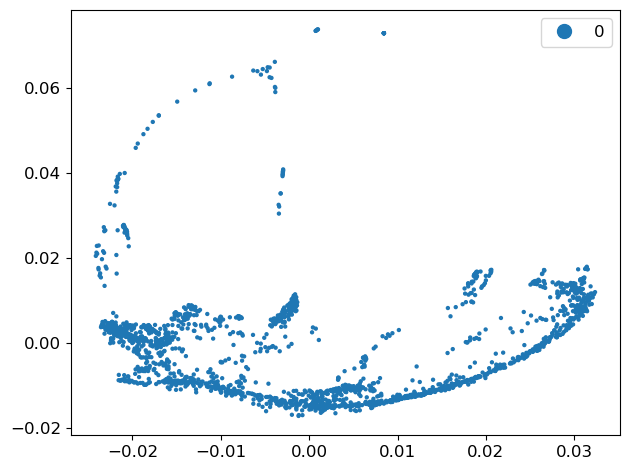

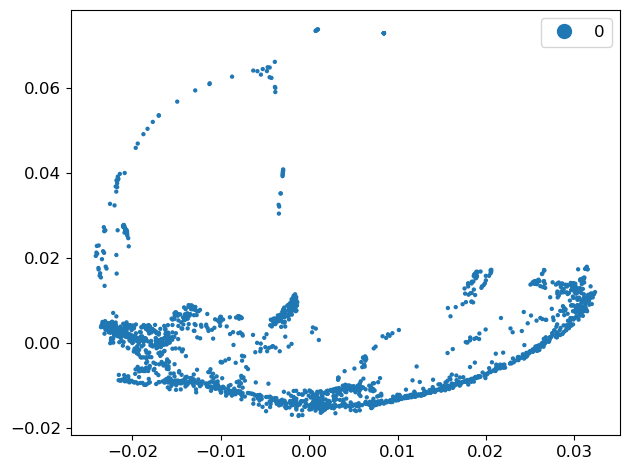

In [212]:
bpp = bpp.fit(adata_pm_ph)